In [1]:
%matplotlib notebook
%load_ext autoreload
from glob import glob
from skimage import io
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
from matplotlib.font_manager import FontProperties
import matplotlib
matplotlib.get_backend()
import joblib as jb
import seaborn as sns
import palettable.colorbrewer as cb
sns.set_palette('colorblind')
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook
from datetime import timedelta
import palettable.cmocean as ocean
from __future__ import unicode_literals
import os
import IPython.display as display
#matplotlib.rcParams['backend'] = 'TkAgg' 
from sklearn import metrics

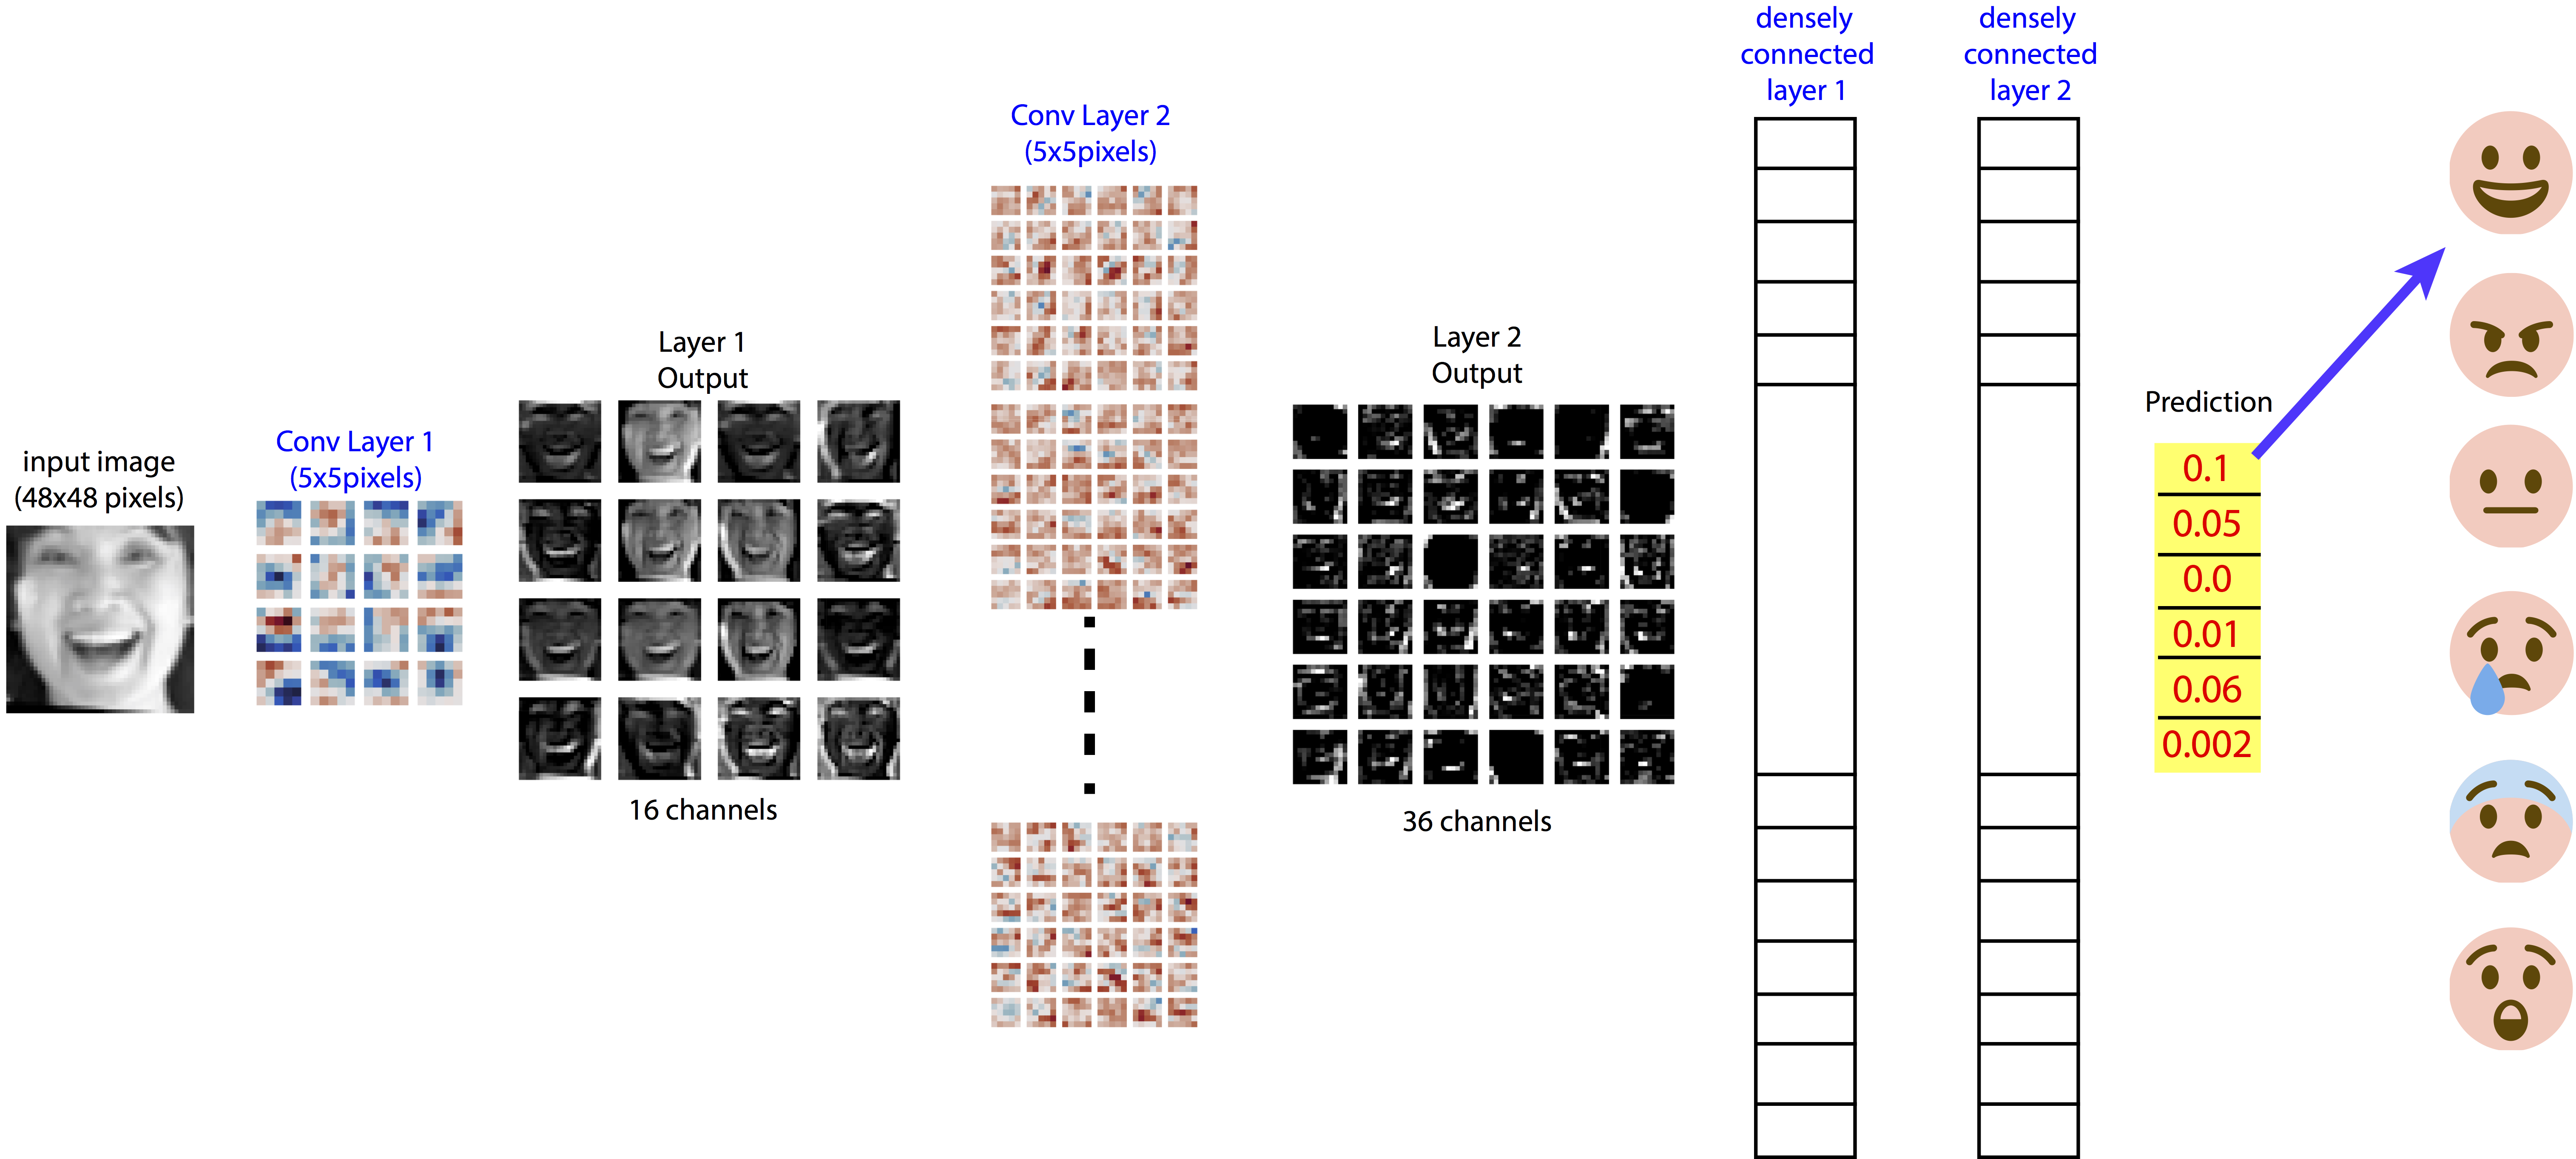

In [2]:
display.Image('Images/layout.png',\
              height=800,width=900)

## Import data

In [3]:
mod_images_dropD=pd.read_pickle('mod_images_dropDigust.pickle')

mod_images_dropD.head()

0         1         2         3         4         5         6  \
0  0.576471  0.584314  0.588235  0.592157  0.603922  0.623529  0.643137   
1  0.000000  0.196078  0.556863  0.560784  0.400000  0.247059  0.431373   
2  0.011765  0.000000  0.137255  0.411765  0.647059  0.729412  0.819608   
3  0.000000  0.000000  0.011765  0.043137  0.094118  0.121569  0.129412   
4  0.439216  0.529412  0.529412  0.509804  0.525490  0.560784  0.568627   

          7         8         9  ...    2295  2296  2297      2298      2299  \
0  0.658824  0.666667  0.662745  ...     0.0   0.0   0.0  0.000000  0.000000   
1  0.529412  0.623529  0.682353  ...     0.0   0.0   0.0  0.000000  0.011765   
2  0.886275  0.878431  0.866667  ...     0.0   0.0   0.0  0.000000  0.000000   
3  0.180392  0.270588  0.352941  ...     0.0   0.0   0.0  0.000000  0.000000   
4  0.541176  0.494118  0.396078  ...     0.0   0.0   0.0  0.003922  0.011765   

       2300      2301      2302      2303  label  
0  0.000000  0.000000  0.000000  0.000000      0  
1  0.129412  0.235294  0.337255  0.364706      0  
2  0.000000  0.000000  0.000000  0.000000      2  
3  0.000000  0.000000  0.000000  0.000000      6  
4  0.023529  0.031373  0.039216  0.050980      2  

[5 rows x 2305 columns]

### Train,Validataion & Test datasets

In [4]:
train, test = train_test_split(mod_images_dropD, test_size = 0.3,\
                                stratify=mod_images_dropD.label.values)

In [5]:
test, validation = train_test_split(test, test_size = 0.5,\
                                stratify=test.label.values)

In [6]:
test_y=pd.get_dummies(test['label']).values
validation_y=pd.get_dummies(validation['label']).values
train_y=pd.get_dummies(train['label']).values

In [7]:
train_x=train.iloc[:,:2304].values
validation_x=validation.iloc[:,:2304].values
test_x=test.iloc[:,:2304].values

### Data Dimension

In [8]:
image_size=48
image_size_flat=image_size*image_size
image_shape=(image_size,image_size)
# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1
num_classes = 6

### Label Dictionary

In [9]:
mod_label_dict={0:['Angry',u'\U0001f620'],1:['Fear',u'\U0001f628'],\
            2:['Happy',u'\U0001f604'],3:['Sad',u'\U0001f622'],4:['Surprise',u'\U0001f632'],\
            5:['Neutral',u'\U0001f610']}
mod_label_dict

{0: ['Angry', '😠'],
 1: ['Fear', '😨'],
 2: ['Happy', '😄'],
 3: ['Sad', '😢'],
 4: ['Surprise', '😲'],
 5: ['Neutral', '😐']}

## Convolutional Network Architecture

In [10]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
dc_size = 128   

## Helper Functions
### Plot Images

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 16
    
    #true_label=[mod_label_dict[i][1] for i in np.argmax(cls_true,axis=1)]
    # Create figure with 4x4 sub-plots.
    fig, axes = plt.subplots(4, 4,figsize=(10,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    if cls_pred is None:
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(48,-1), cmap='gray')
        label_color='blue'
        true_=np.argmax(cls_true[i])
        if cls_pred is None:
            xlabel = "{} : {}".format(mod_label_dict[true_][0],mod_label_dict[true_][1])
        else:
            
            pred_=np.argmax(cls_pred[i])
            xlabel = "{0} : {1}".\
            format(mod_label_dict[true_][0], mod_label_dict[pred_][0])
            
    
            if true_ != pred_:
                label_color='red'
        
        ax.set_xlabel(xlabel,color=label_color,fontname='DejaVu Sans',fontsize=20)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.tight_layout()

    

#### Plot some images

<IPython.core.display.Javascript object>


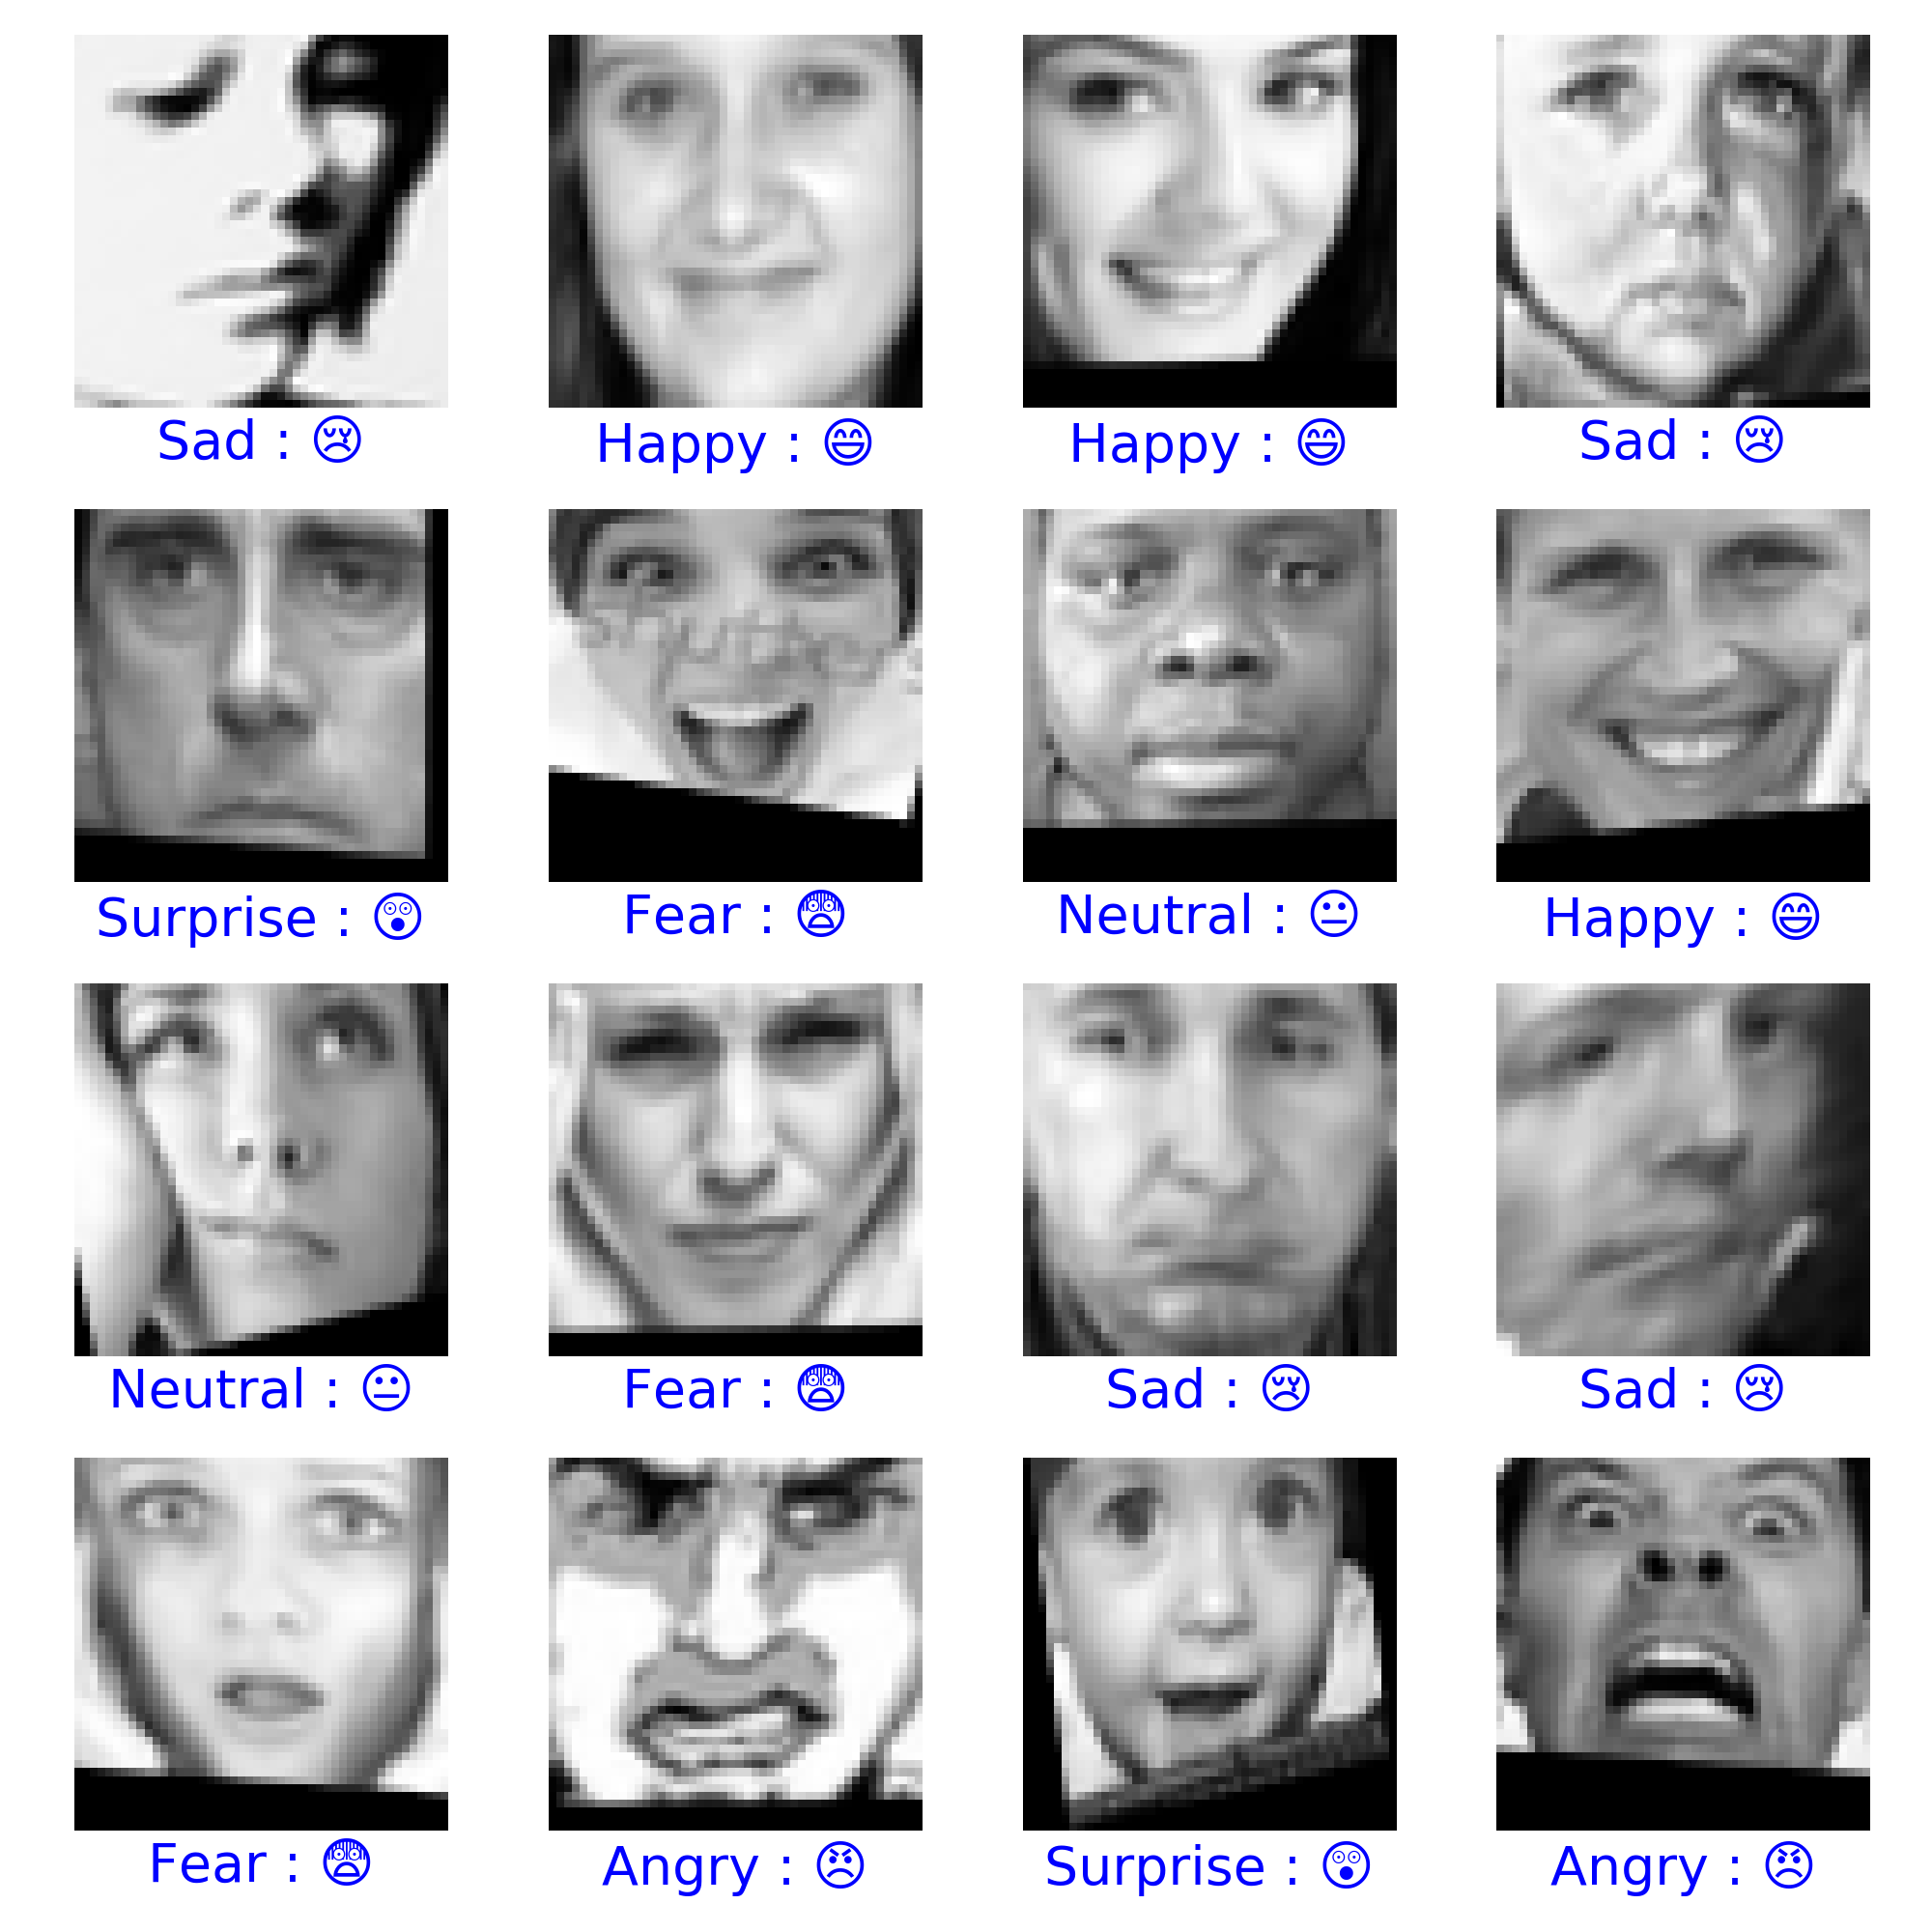

In [12]:
images = train_x[10:26]
cls_true = train_y[10:26]
plot_images(images=images, cls_true=cls_true)

### Generate weights and biases 

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Layer Construction Functions 

In [14]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [15]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [16]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

## Construct Model
### Placeholder variables

In [17]:
x = tf.placeholder("float", shape=[None, image_size_flat],\
                   name='x')
image_x = tf.reshape(x, \
                   [-1,image_size,image_size,\
                    num_channels])
y=tf.placeholder("float",\
                      shape=[None,num_classes],\
                       name='y')


In [36]:
tf.add_to_collection('vars', x)
tf.add_to_collection('vars', y)
#tf.add_to_collection('vars', keep_prob)

### Convolutional Layer 1

In [18]:
L1_conv, W1_conv=\
new_conv_layer(input = image_x,\
               num_input_channels=num_channels,\
               filter_size=filter_size1,
               num_filters=num_filters1,
               use_pooling=True)

print(L1_conv)
print(W1_conv)

Tensor("Relu:0", shape=(?, 24, 24, 16), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>


### Convolutional Layer 2

In [19]:
L2_conv, W2_conv=\
new_conv_layer(input = L1_conv,\
               num_input_channels=num_filters1,\
               filter_size=filter_size2,
               num_filters=num_filters2,
               use_pooling=True)

print(L2_conv)
print(W2_conv)

Tensor("Relu_1:0", shape=(?, 12, 12, 36), dtype=float32)
<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>


### Prepare for Densely Connected Layer [ Flatten Input For DL]

In [20]:
L_flat, num_features = flatten_layer(L2_conv)
print(L_flat)
print(num_features)

Tensor("Reshape_1:0", shape=(?, 5184), dtype=float32)
5184


### Densely Connected Layer 1

In [21]:
L1_dc = new_fc_layer(input=L_flat,
                         num_inputs=num_features,
                         num_outputs=dc_size,
                         use_relu=True)

### Densely Connected Layer 2

In [22]:
L2_dc = new_fc_layer(input=L1_dc,
                         num_inputs=dc_size,
                         num_outputs=num_classes,
                         use_relu=False)

## Prediction 

In [23]:
y_pred=tf.nn.softmax(L2_dc)
print(y_pred)

Tensor("Softmax:0", shape=(?, 6), dtype=float32)


In [24]:
y_pred_val=tf.argmax(y_pred,dimension=1)
print(y_pred_val)

Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Cost-Function For Optimization

In [25]:
cross_entropy = \
tf.nn.softmax_cross_entropy_with_logits(\
                                        logits=L2_dc,
                                        labels=y)

cost=tf.reduce_mean(cross_entropy)

In [26]:
# optimizer = tf.train.AdamOptimizer(\
#                                    learning_rate=1e-4).minimize(cost)
optimizer=tf.train.RMSPropOptimizer(0.0005, 0.9).minimize(cost)

In [27]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


## TensorFlow Session



In [28]:
session = tf.Session()
saver = tf.train.Saver(max_to_keep=10000)

### Initialize variables


In [29]:
session.run(tf.global_variables_initializer())

In [30]:
batch_size=64
total_iterations=0
inc=0
result_dict={'Minibatch accuracy':[],'Validation accuracy':[],\
             'Minibatch loss':[],'test_score':[]}
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations,result_dict,inc
    total_iterations += num_iterations
    # Start-time used for printing time-usage below.
    start_time = time.time()

#     for i in range(total_iterations,
#                    total_iterations + num_iterations):
    fig,ax = plt.subplots(1,4,figsize=(12,4))
    ax=ax.ravel()
    fig.show()
    #
    
    
    #####
    ##### 'b' is for random shuffle index. 
    b=np.arange(len(train_x))
    
    batch_list=list(zip(\
                   range(0, len(train_x), batch_size),\
                   range(batch_size, len(train_x)+1, batch_size)))
    N=len(list(batch_list))
    #print(list(batch_list),N)
    full_loop=num_iterations//N if num_iterations%N == 0 else 1+num_iterations//N
    
    #writer = tf.summary.FileWriter('logs', sess.graph)
    for step in tnrange(full_loop,desc="Progress"):
        
        np.random.shuffle(b)
        for count,(start, end) in enumerate(batch_list):
            index=b[start:end]
            inc +=1
            if num_iterations ==0:
                break
            

        
            feed_dict_train={x: train_x[index], y: train_y[index]}
            #print(feed_dict_train)
            _,l,predictions=session.run([optimizer,cost,y_pred], feed_dict=feed_dict_train)

    
            if (count % 64 == 0 and count != 0):
            # Calculate the accuracy on the training-set.
                #acc = session.run(accuracy, feed_dict=feed_dict_)
                feed_dict_valid={x: validation_x}
                valid_predict=session.run(y_pred, feed_dict=feed_dict_valid)
    #             # Message for printing.
    #             msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

    #             # Print it.
    #             print(msg.format(i + 1, acc))
                result_dict['Minibatch accuracy'].append(accuracy(predictions, train_y[index]))
                #result_dict['count'].append(inc*100)
                result_dict['Minibatch loss'].append(l)
                result_dict['Validation accuracy'].append(accuracy(valid_predict, validation_y))
                
                inc += 1
                for num,key in enumerate(result_dict.keys()):
                    ax[num].clear()
                    #ax[num].grid(False)
                    resulty=result_dict[key]
                    ax[num].plot(np.arange(len(resulty))*batch_size,resulty,'r.-',markersize=12)
                    ax[num].set_title(key)
                fig.canvas.draw()
                
        num_iterations = num_iterations -1
    
    

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time
    
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    print("Iteration: "+str(total_iterations))

## Training
### Train and Save models at every 1000 iterations

<IPython.core.display.Javascript object>


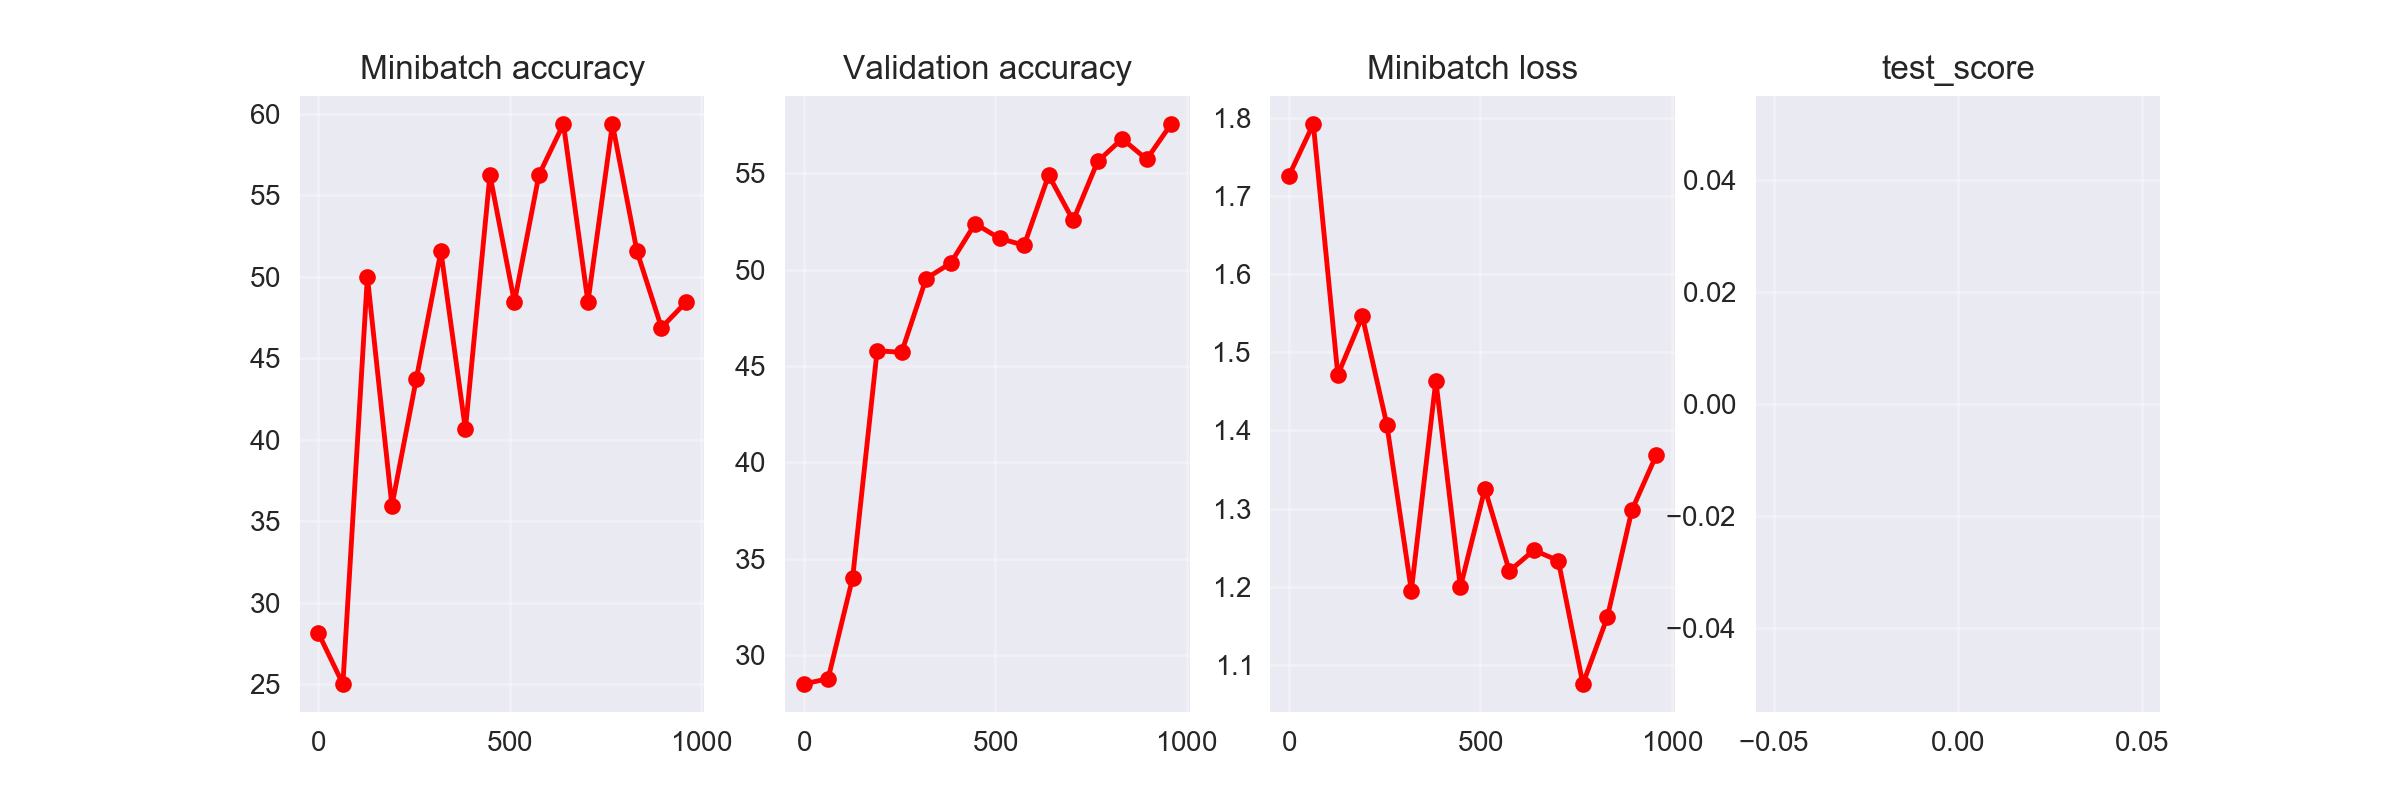


Time usage: 0:03:31
Iteration: 1000


<IPython.core.display.Javascript object>


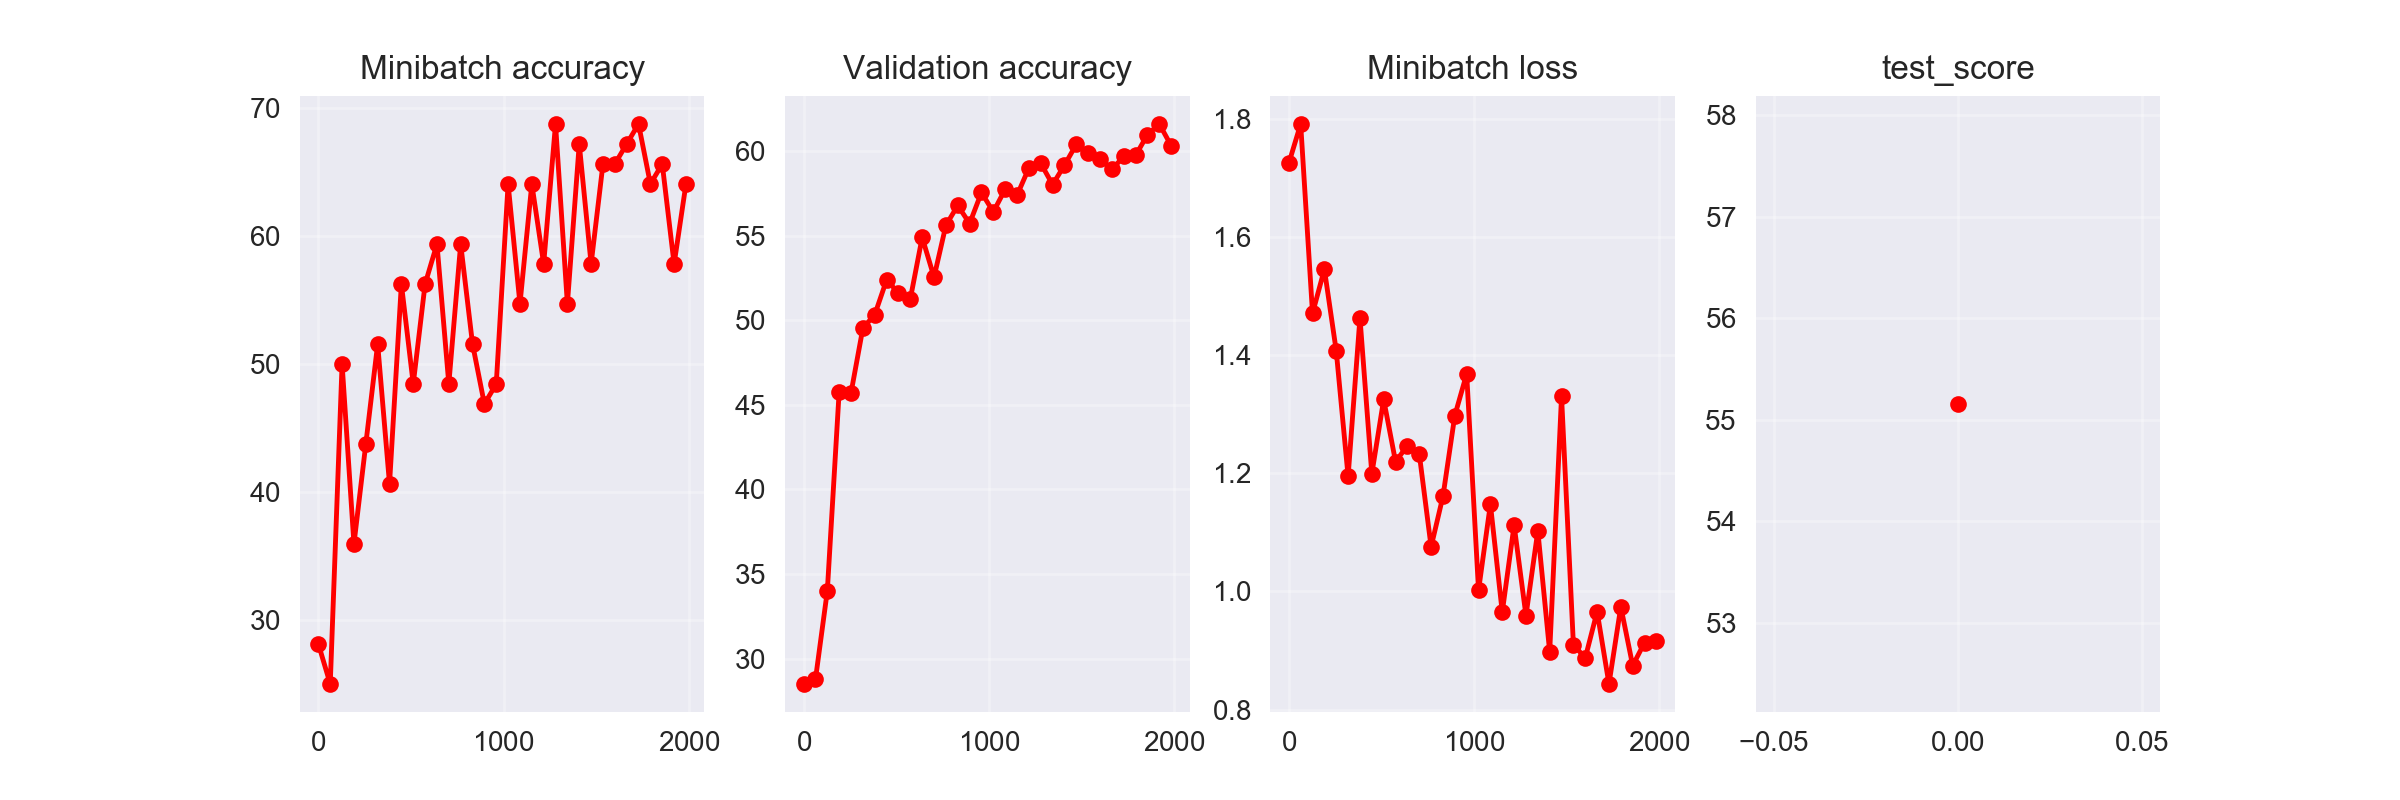


Time usage: 0:03:16
Iteration: 2000


<IPython.core.display.Javascript object>


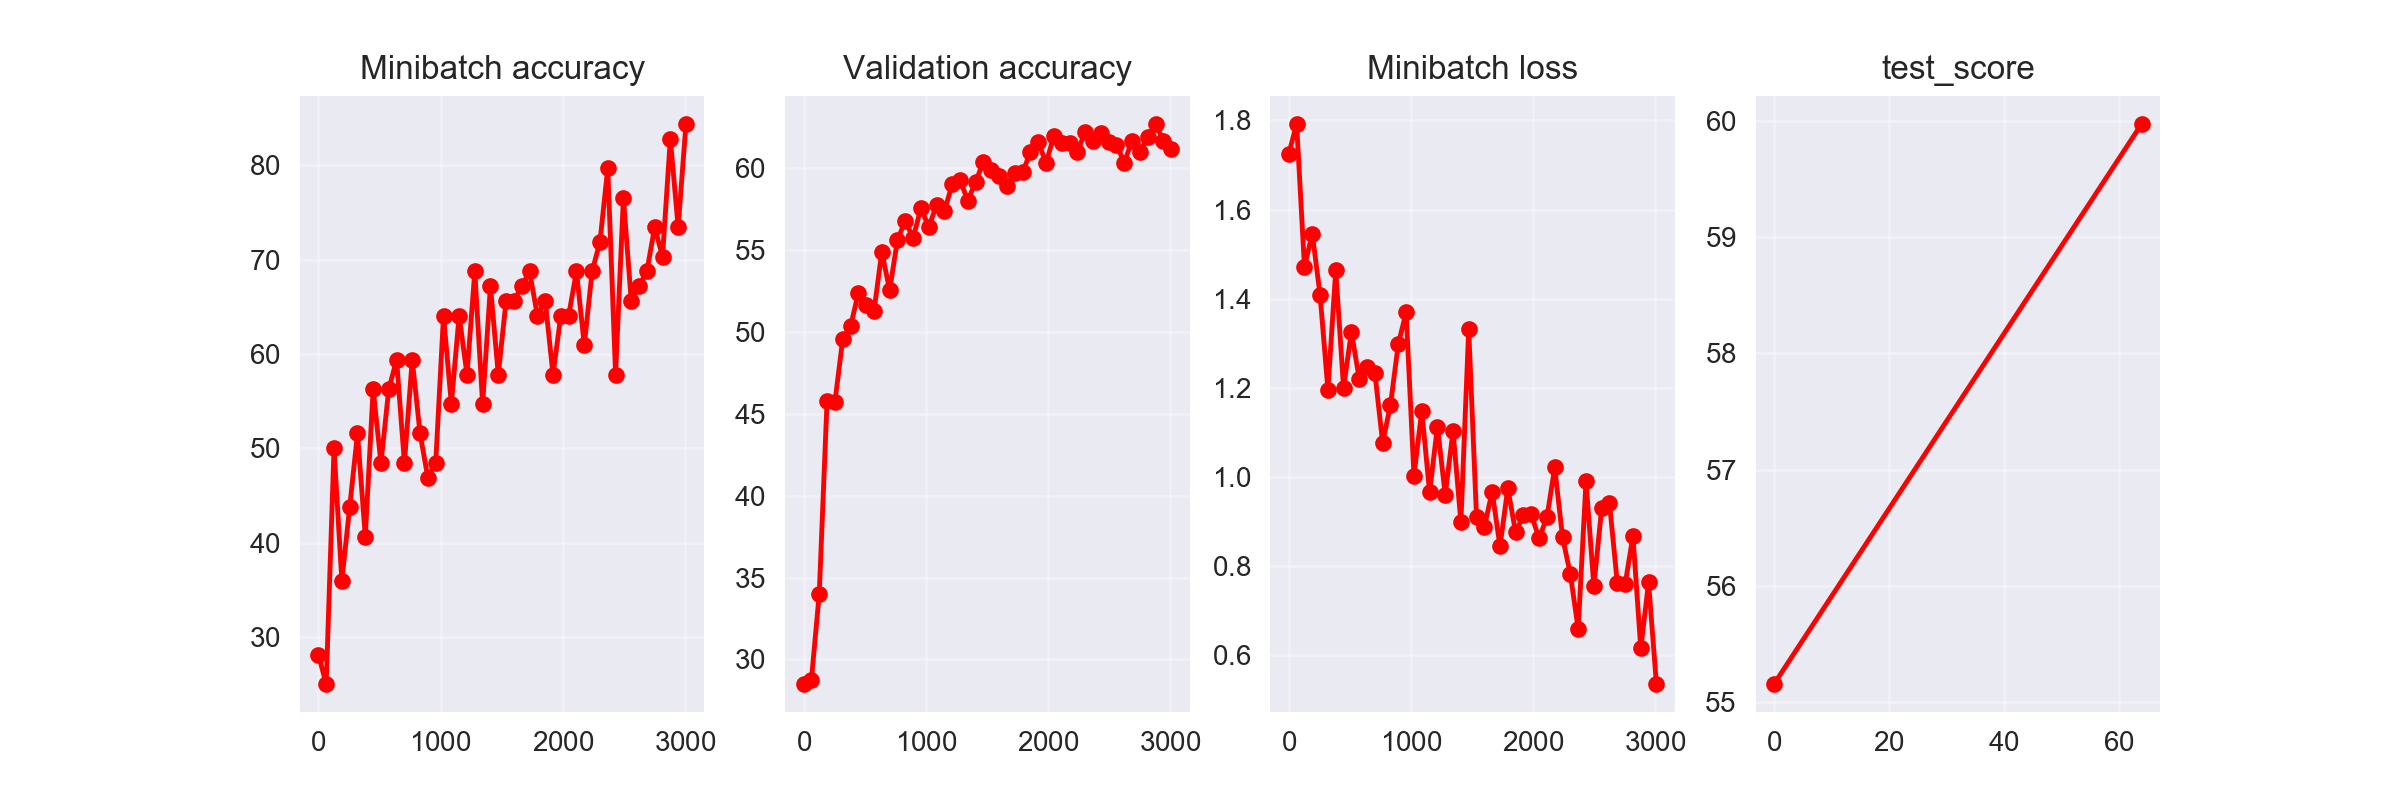


Time usage: 0:03:19
Iteration: 3000


<IPython.core.display.Javascript object>


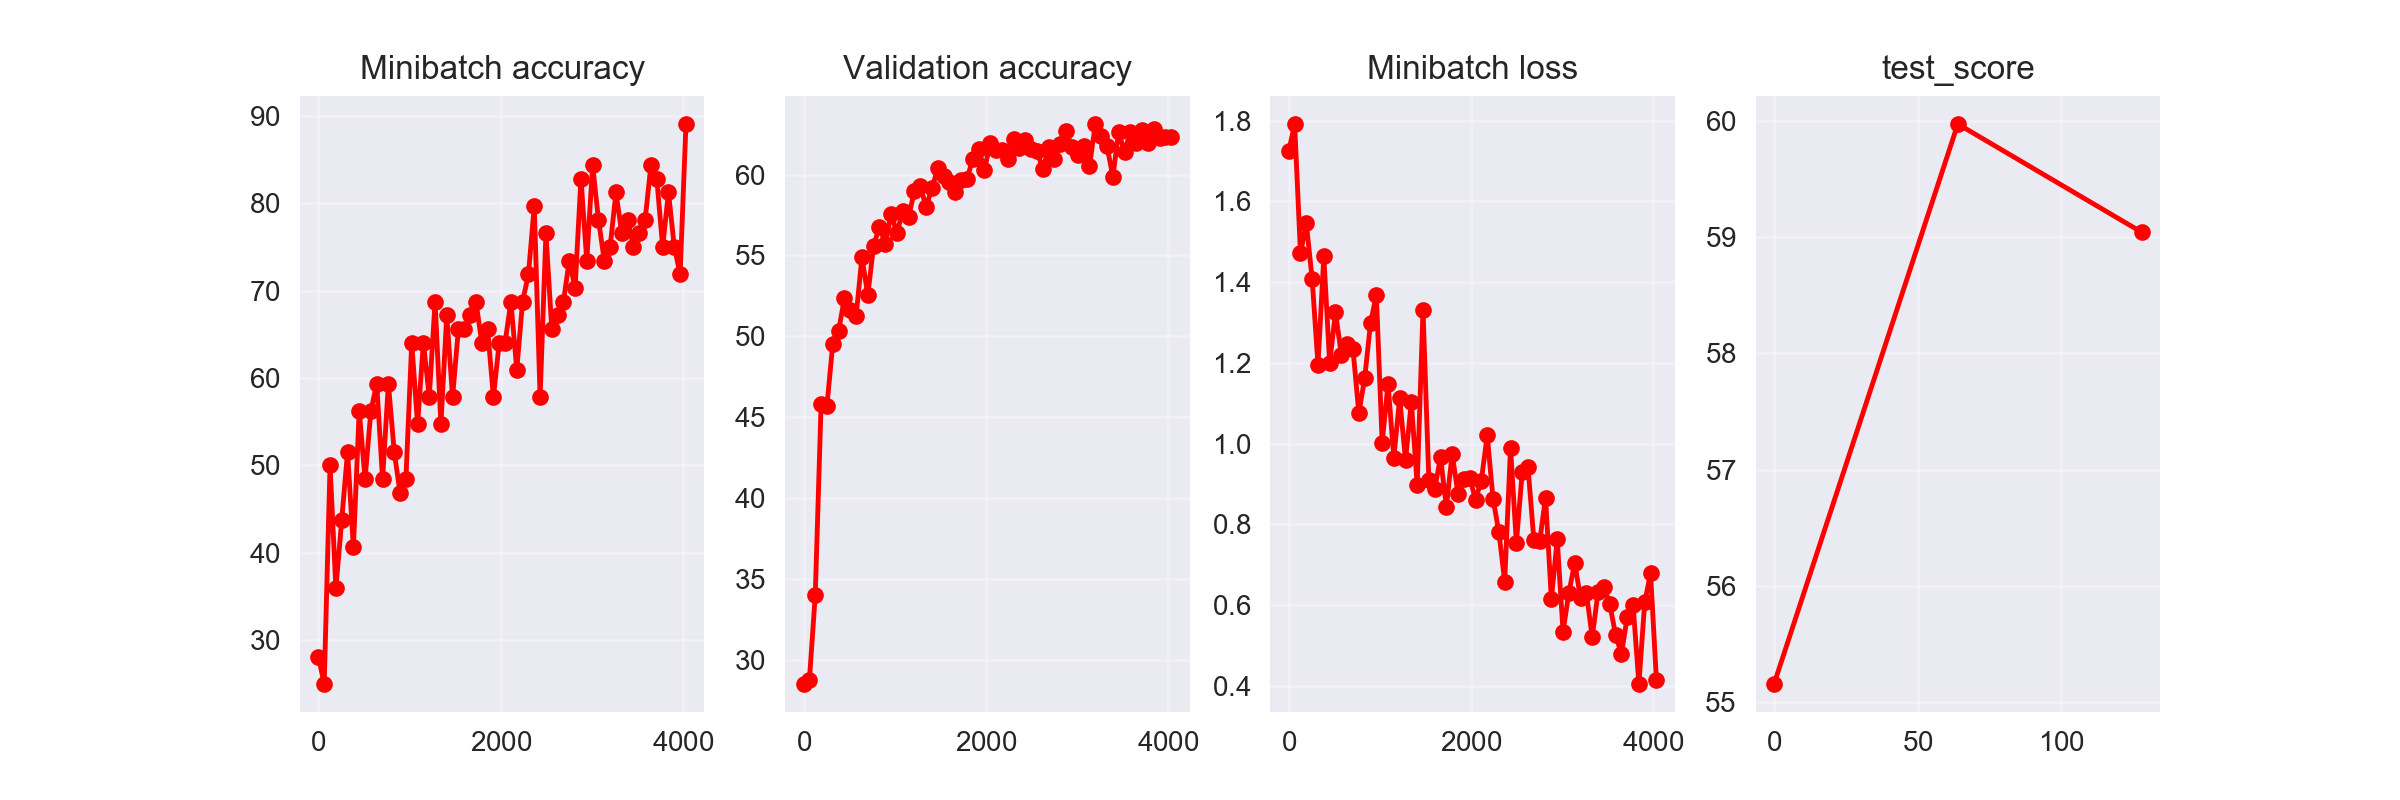


Time usage: 0:03:11
Iteration: 4000


<IPython.core.display.Javascript object>


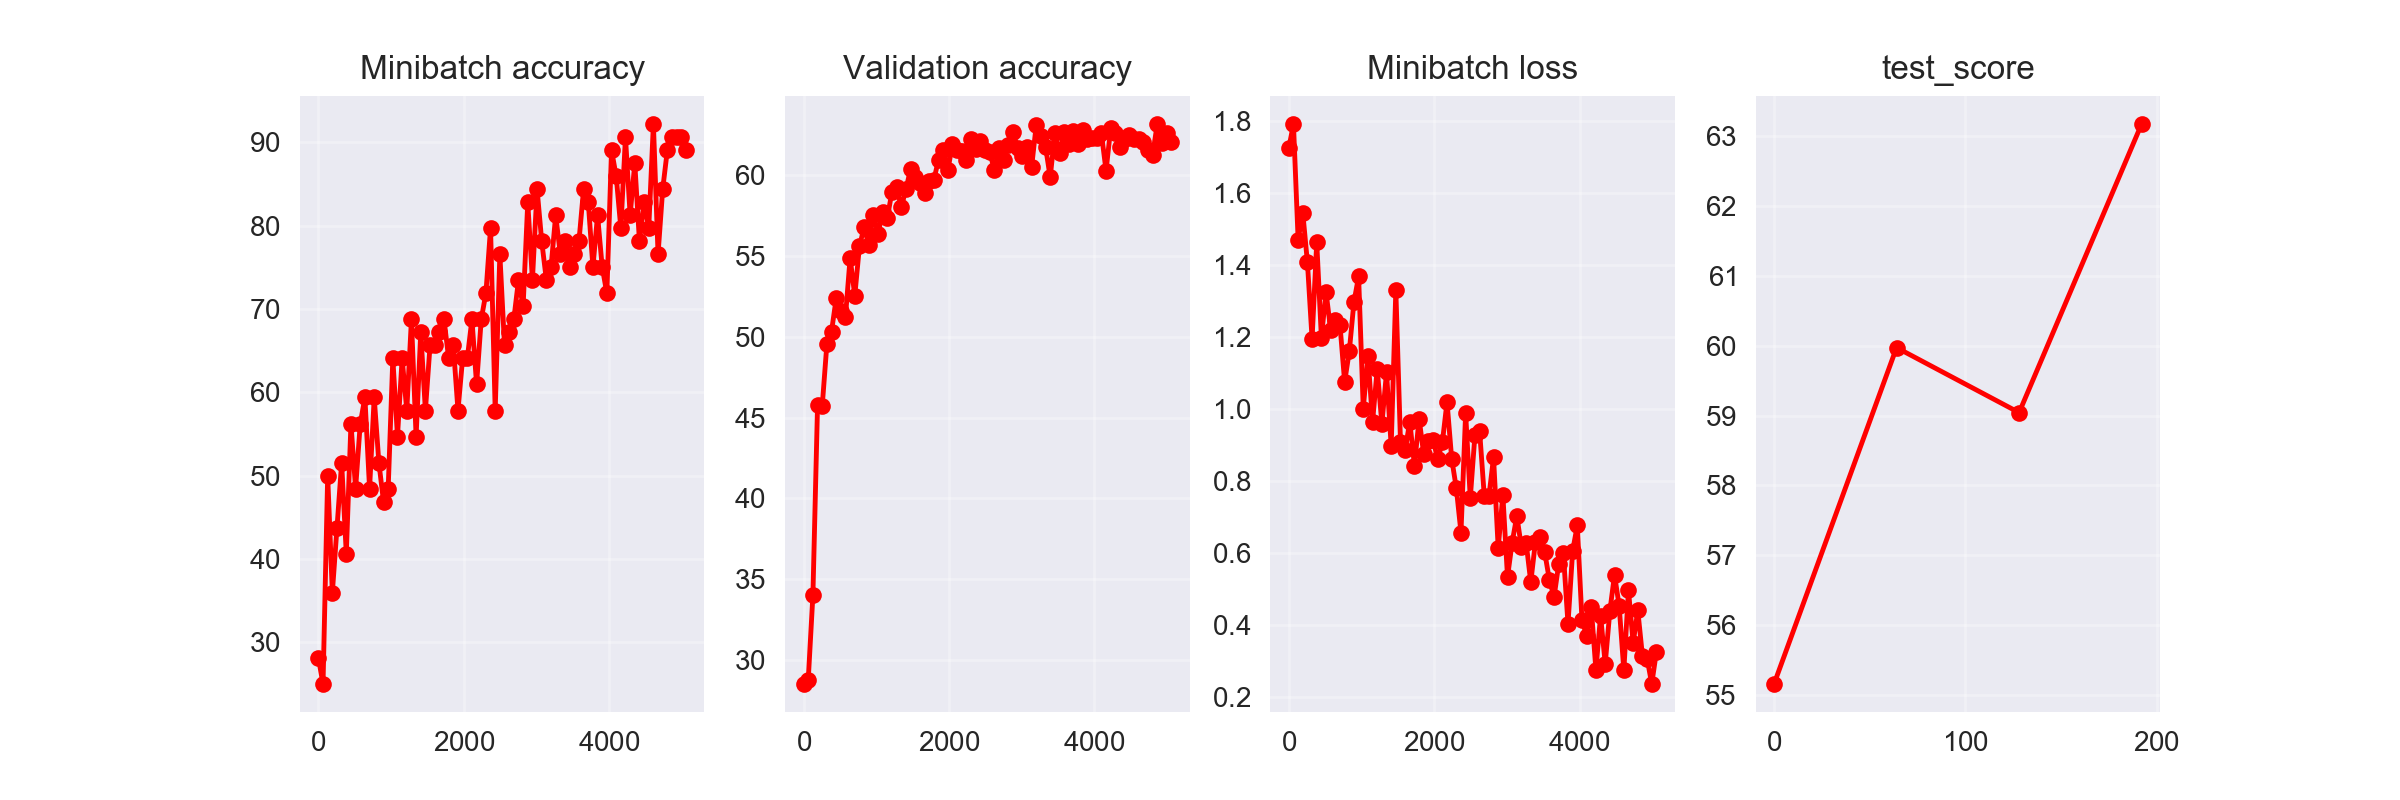


Time usage: 0:03:09
Iteration: 5000


<IPython.core.display.Javascript object>


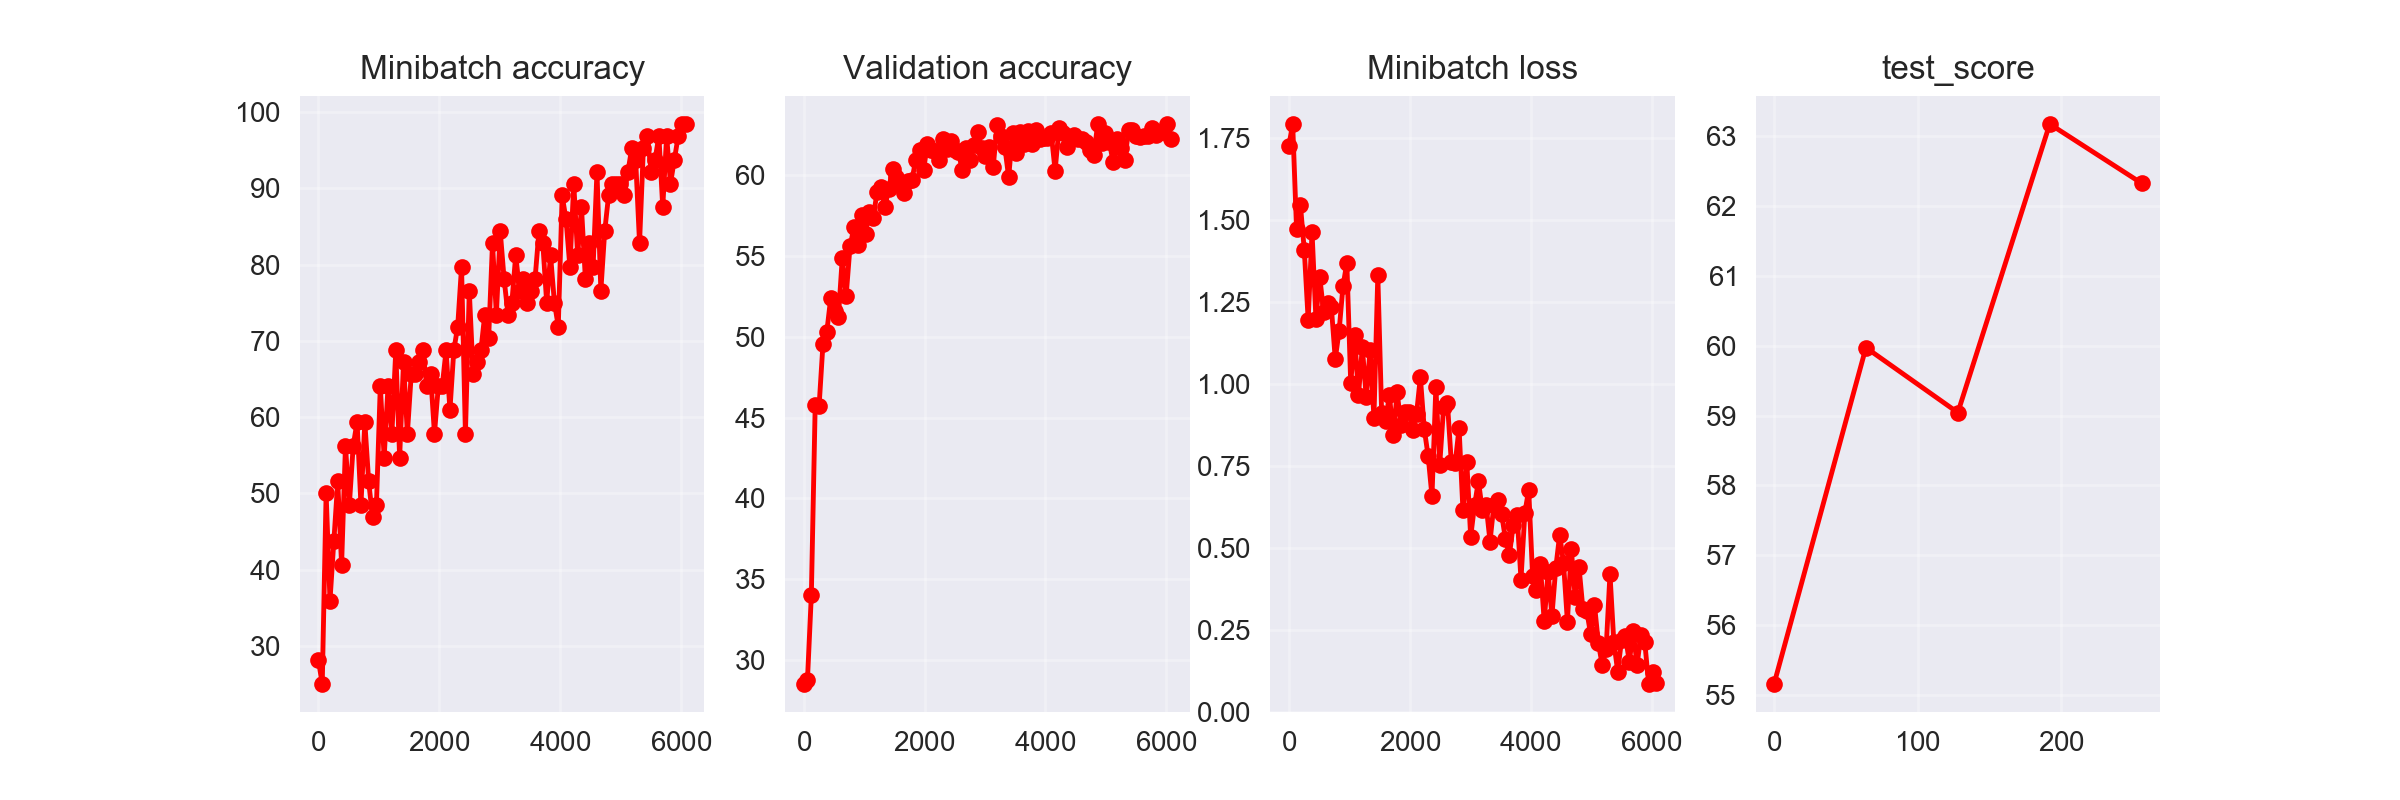


Time usage: 0:03:10
Iteration: 6000


<IPython.core.display.Javascript object>


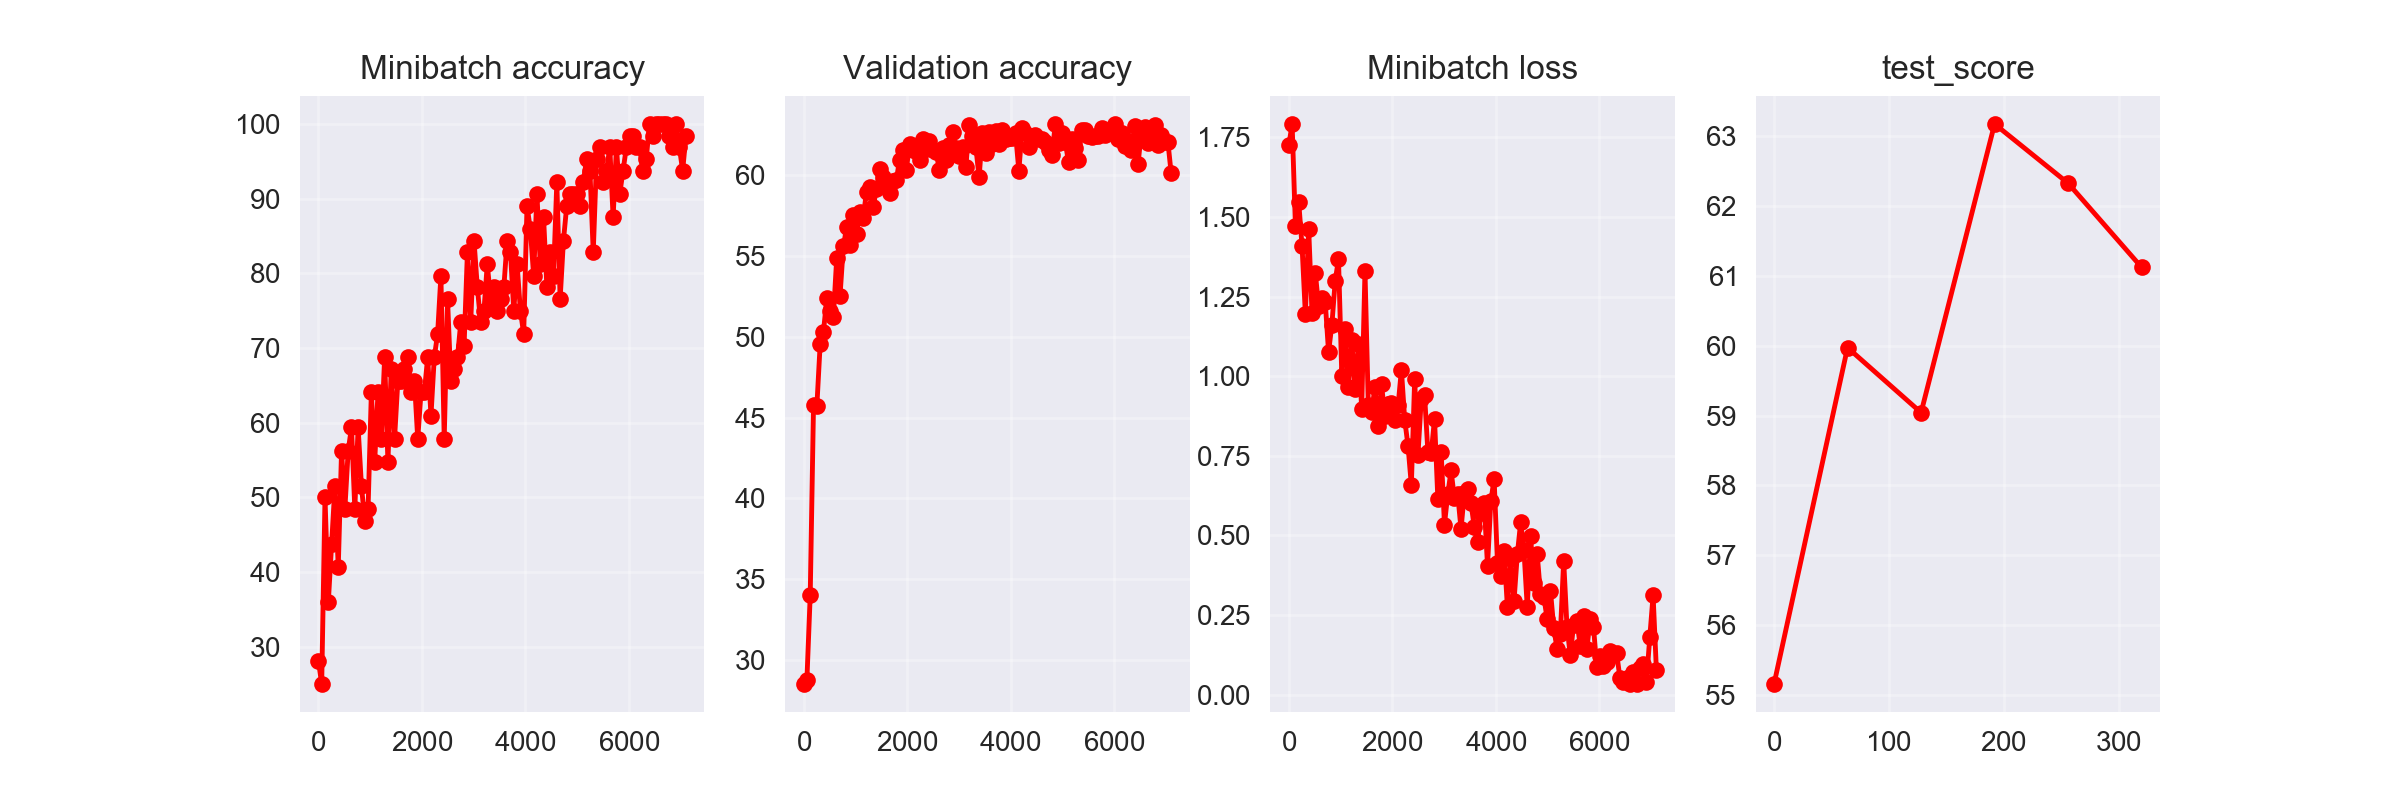


Time usage: 0:03:18
Iteration: 7000


<IPython.core.display.Javascript object>


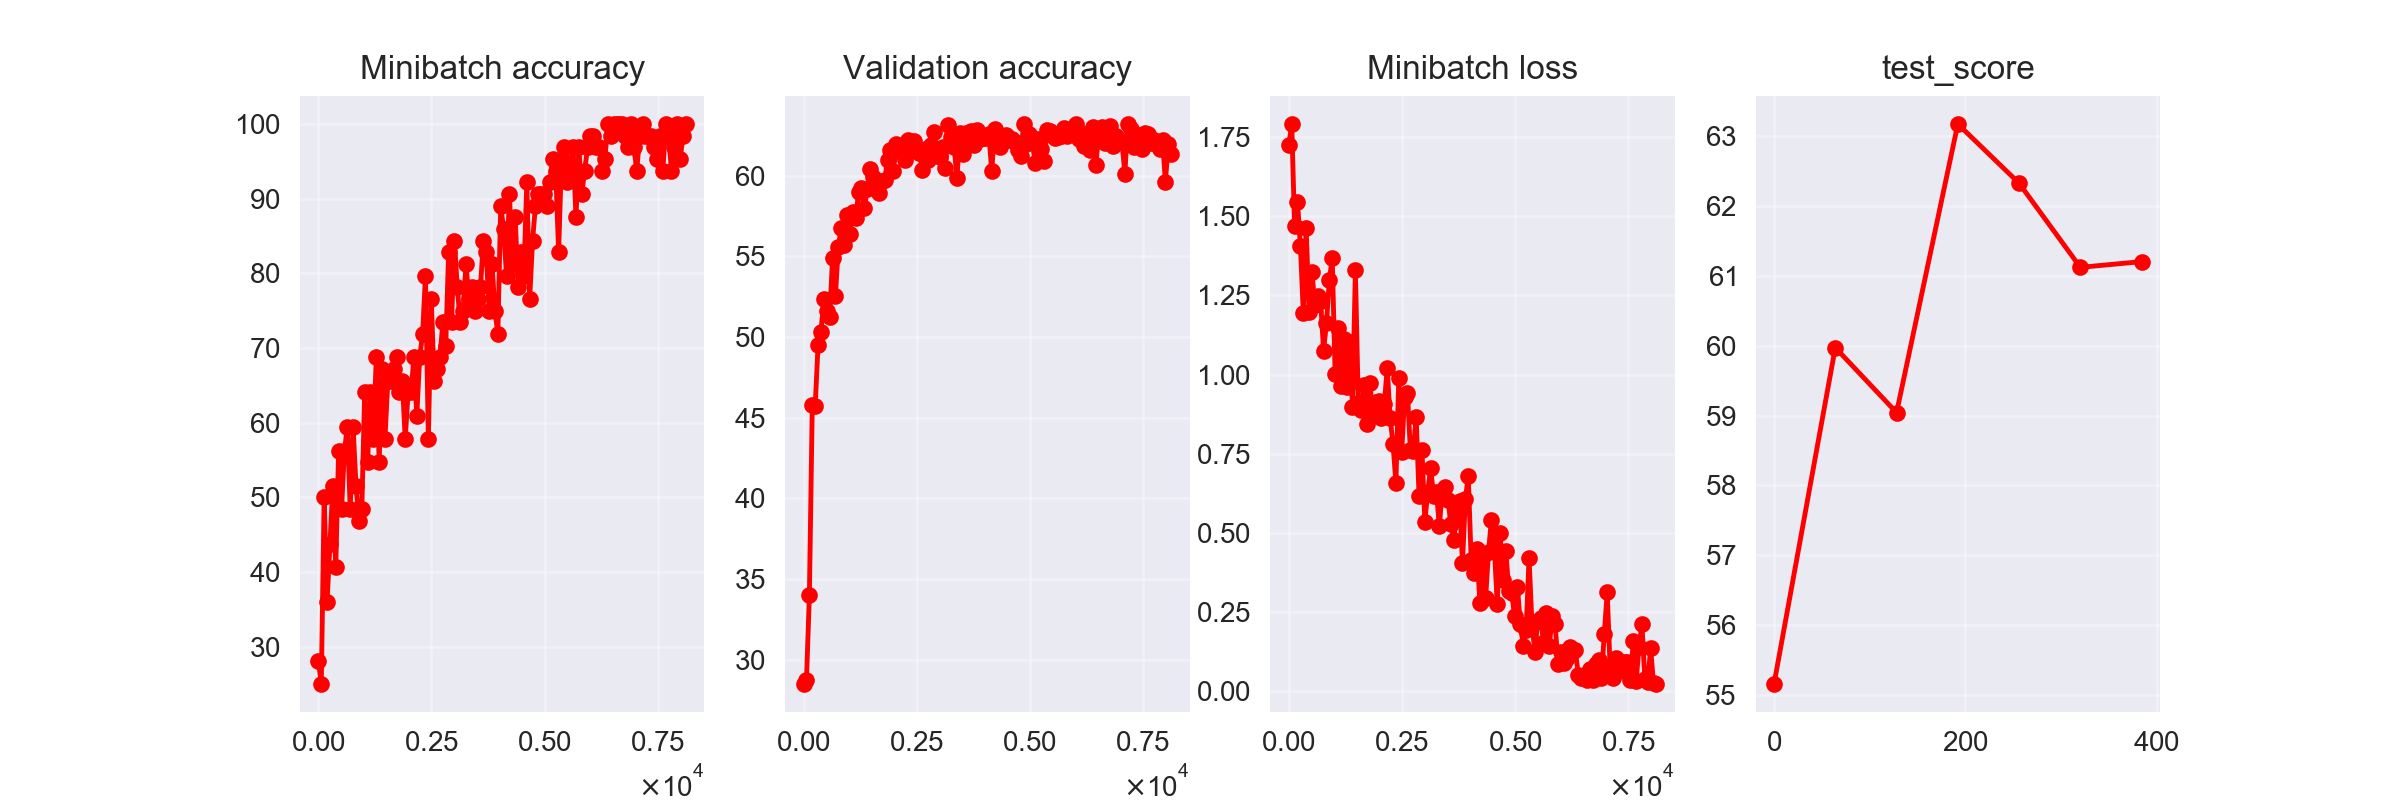


Time usage: 0:03:20
Iteration: 8000


<IPython.core.display.Javascript object>


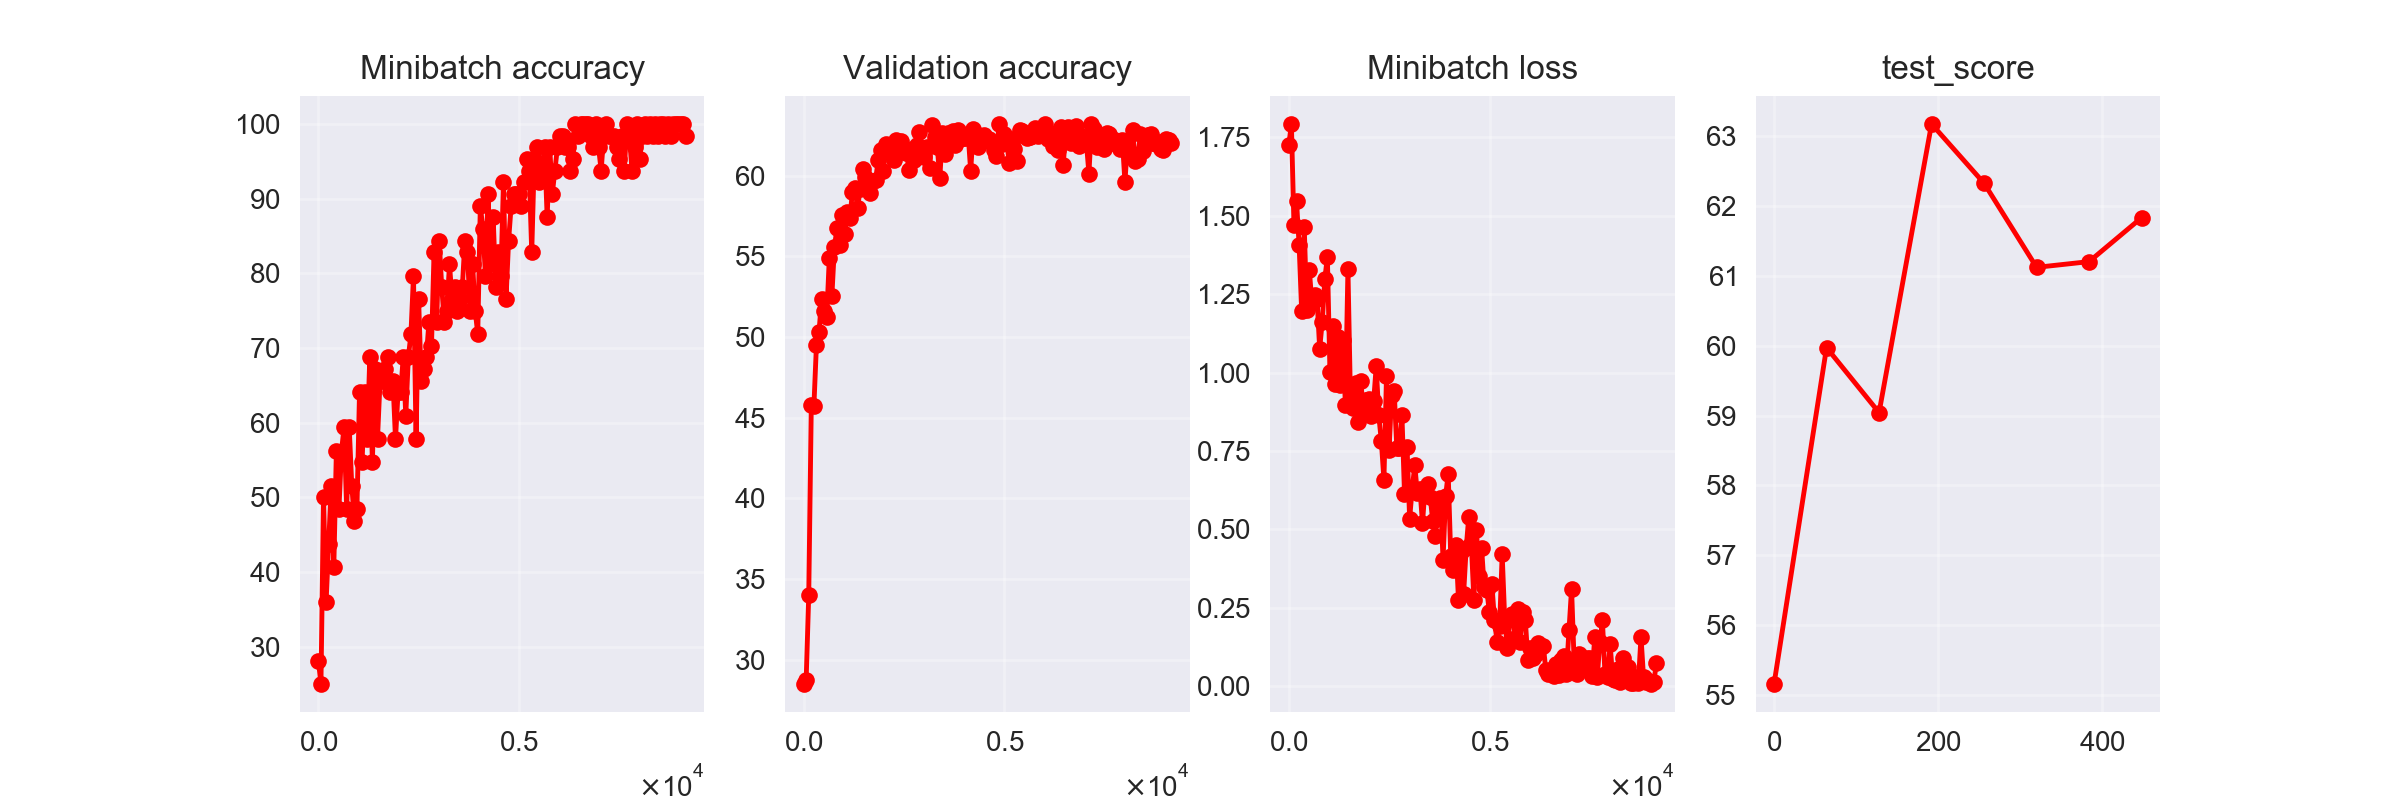


Time usage: 0:03:24
Iteration: 9000


<IPython.core.display.Javascript object>


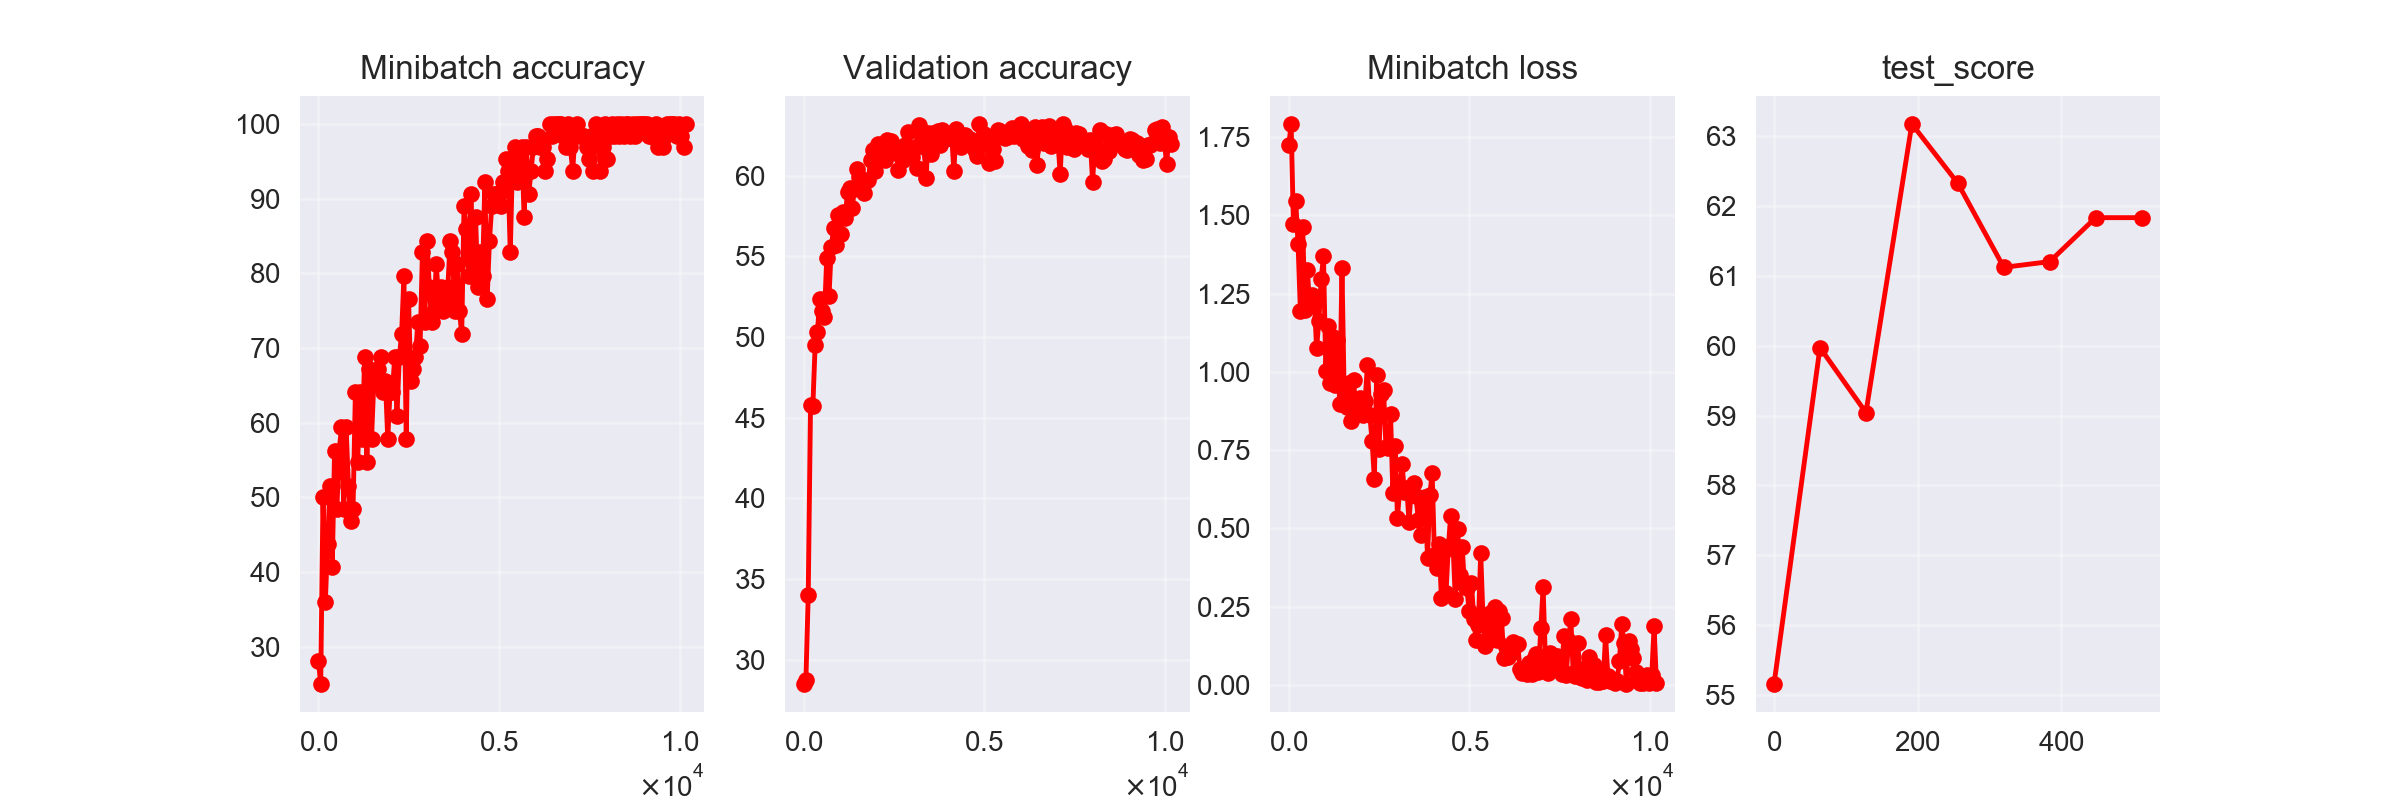


Time usage: 0:03:22
Iteration: 10000


In [32]:
for i in range(10):
    optimize(num_iterations=1000)
    test_predict=session.run(y_pred, feed_dict={x: test_x})
    xx=accuracy(test_predict,test_y)
    score=np.round(xx*100)
    result_dict['test_score'].append(xx)
    fname='1stmodel_{}_{}'.format(inc,score)
    jb.dump(result_dict,'1stmodel_checkpoints_2/result_dict_'+fname+'.pkl')
    saver.save(sess=session, save_path='1stmodel_checkpoints_2/'+fname)

In [58]:
result_dict=jb.load('1stmodel_checkpoints_2/result_dict_1stmodel_10800_6230.0.pkl')
np.mean(np.array(result_dict['test_score'])[3:])

61.969904240766077

In [47]:
import matplotlib as mpl
#mpl.style("ggplot")
plt.style.use('ggplot')

<IPython.core.display.Javascript object>


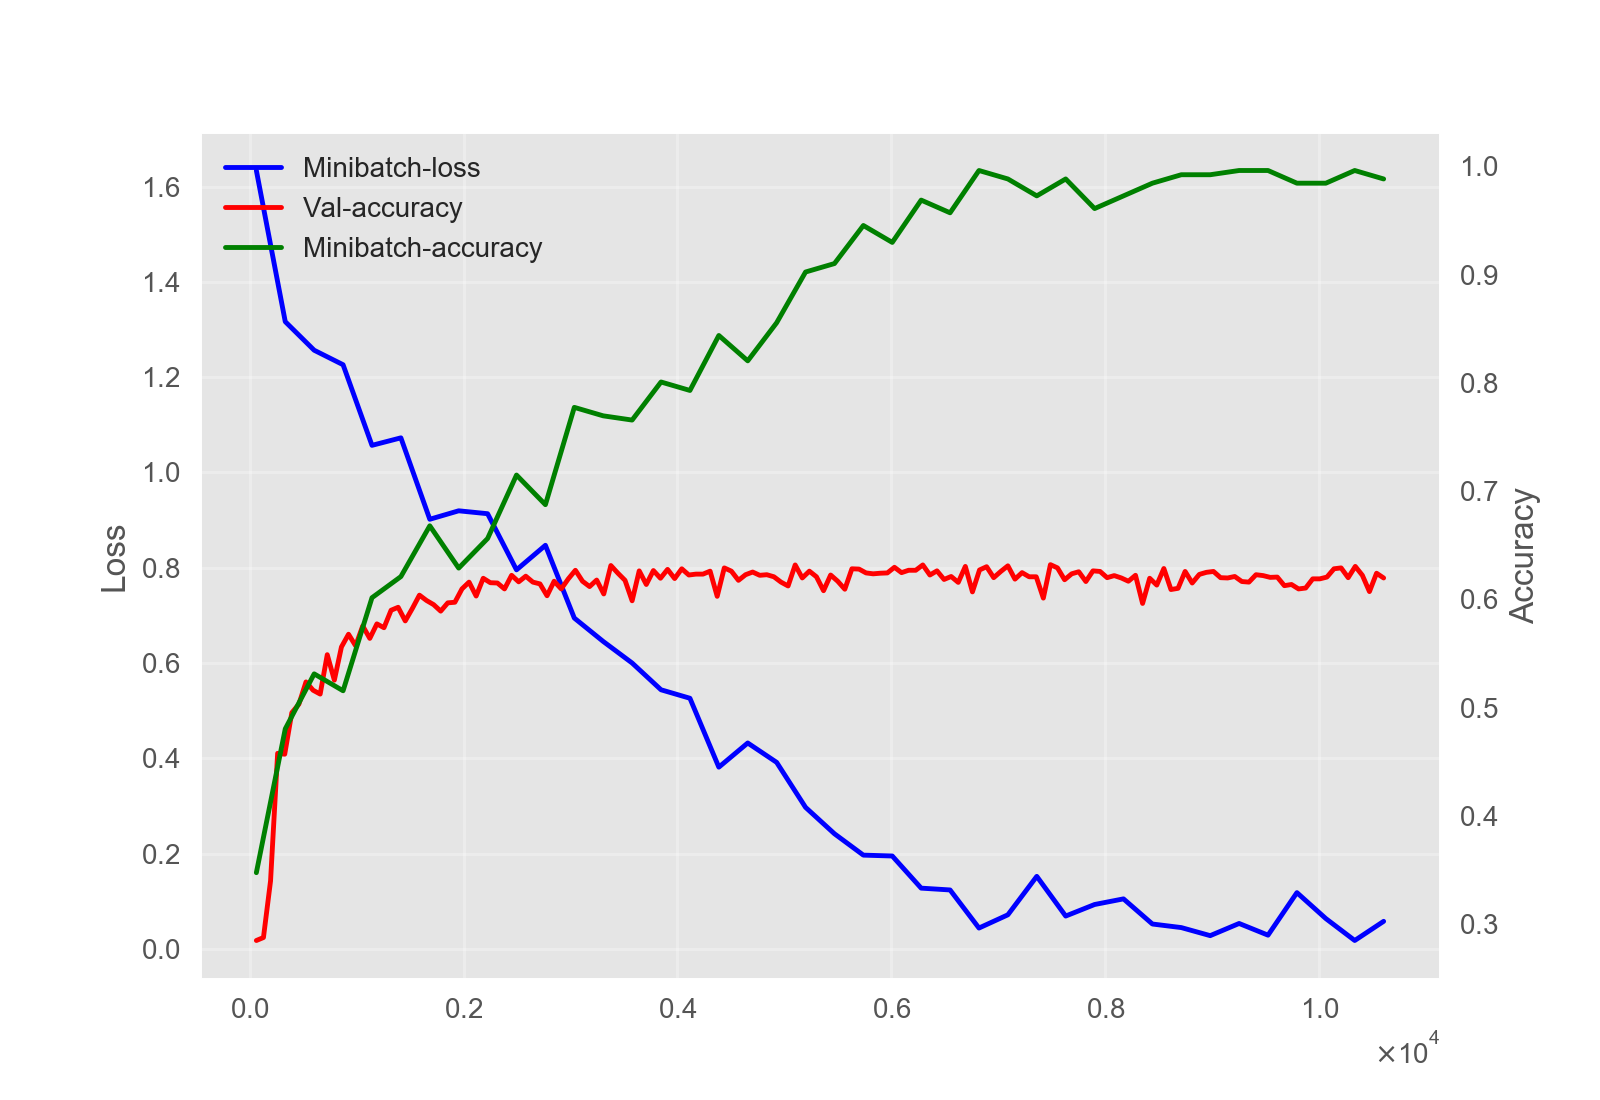

/Users/thein/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()
/Users/thein/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [48]:
fig,ax=plt.subplots()
#plt.plot(np.linspace(64,10600,160),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy')
ax.plot(np.linspace(64,10600,160/4),np.mean(np.array(result_dict['Minibatch loss']).reshape(-1,4),1),label='Minibatch-loss',color='b')
#plt.plot(np.linspace(64,10600,160),np.array(result_dict['V loss']),label='Minibatch-loss')
#plt.legend(loc='center right')
ax2=ax.twinx()
ax2.plot(np.linspace(64,10600,160),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy',color='r')
ax2.plot(np.linspace(64,10600,160/4),np.mean(np.array(result_dict['Minibatch accuracy']).reshape(-1,4),1)/100.0,label='Minibatch-accuracy',color='g')
ax.plot(np.nan, '-r', label = 'Val-accuracy')
ax.plot(np.nan, '-g', label = 'Minibatch-accuracy')
ax.legend(loc='upper left')
plt.xlabel('Iterations')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.grid(False)
fig.savefig('Images/1st_model_accuracy.pdf',transparent=False)

### Average Accuracy of the Model

## Restore the most accurate model

In [44]:
tf.reset_default_graph()
saver.restore(sess=session,save_path='1stmodel_checkpoints_2/1stmodel_4320_6317.0')

INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_4320_6317.0


In [45]:
test_predict=session.run(y_pred, feed_dict={x: test_x})
xx=accuracy(test_predict,test_y)

xx

63.17373461012312

## More Helper Functions

In [248]:
def plot_confusion_matrix(predictions, y_test,classes,
                          normalize=False,
                          title='Confusion matrix',
                          #cmap=cb.diverging.RdYlBu_11_r.mpl_colormap):
                          cmap=cb.sequential.YlGn_9.mpl_colormap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Compute confusion matrix
    predictions=np.argmax(predictions,1)
    y_test=np.argmax(y_test,1)
    cm = metrics.confusion_matrix(y_test, predictions)
    np.set_printoptions(precision=2)
    fig, ax1 = plt.subplots()    
    
    if normalize:
        np.set_printoptions(precision=2)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print("Normalized confusion matrix")
        cm=np.round(cm,2)
    else:
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print('Confusion matrix, without normalization')
        
    
    
    plt.title(title)
    plt.colorbar(p)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)




In [231]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    
    feed_dict_test={x: test_x}
    #test_predict=session.run(y_pred, feed_dict=feed_dict_test)
    # Calculate the predicted class using TensorFlow.
    msg = "Accuracy on Test-Set: {:0.2f}%"
    print(msg.format(accuracy(test_predict,test_y)))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        correct=np.argmax(test_y,axis=1) == np.argmax(test_predict,axis=1)
        
        
        images = test_x[~correct][:16]
        cls_true = test_y[~correct][:16]
        cls_pred= test_predict[~correct][:16]
        plot_images(images=images, cls_true=cls_true,cls_pred=cls_pred)
        #return cls_true,cls_pred
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        cls_list=np.array(list(mod_label_dict.values()))[:,0]
        plot_confusion_matrix(predictions=test_predict,y_test=test_y,classes=cls_list)

## Print the Result with some wrong predicted images

Accuracy on Test-Set: 62.38%
Example errors:


<IPython.core.display.Javascript object>


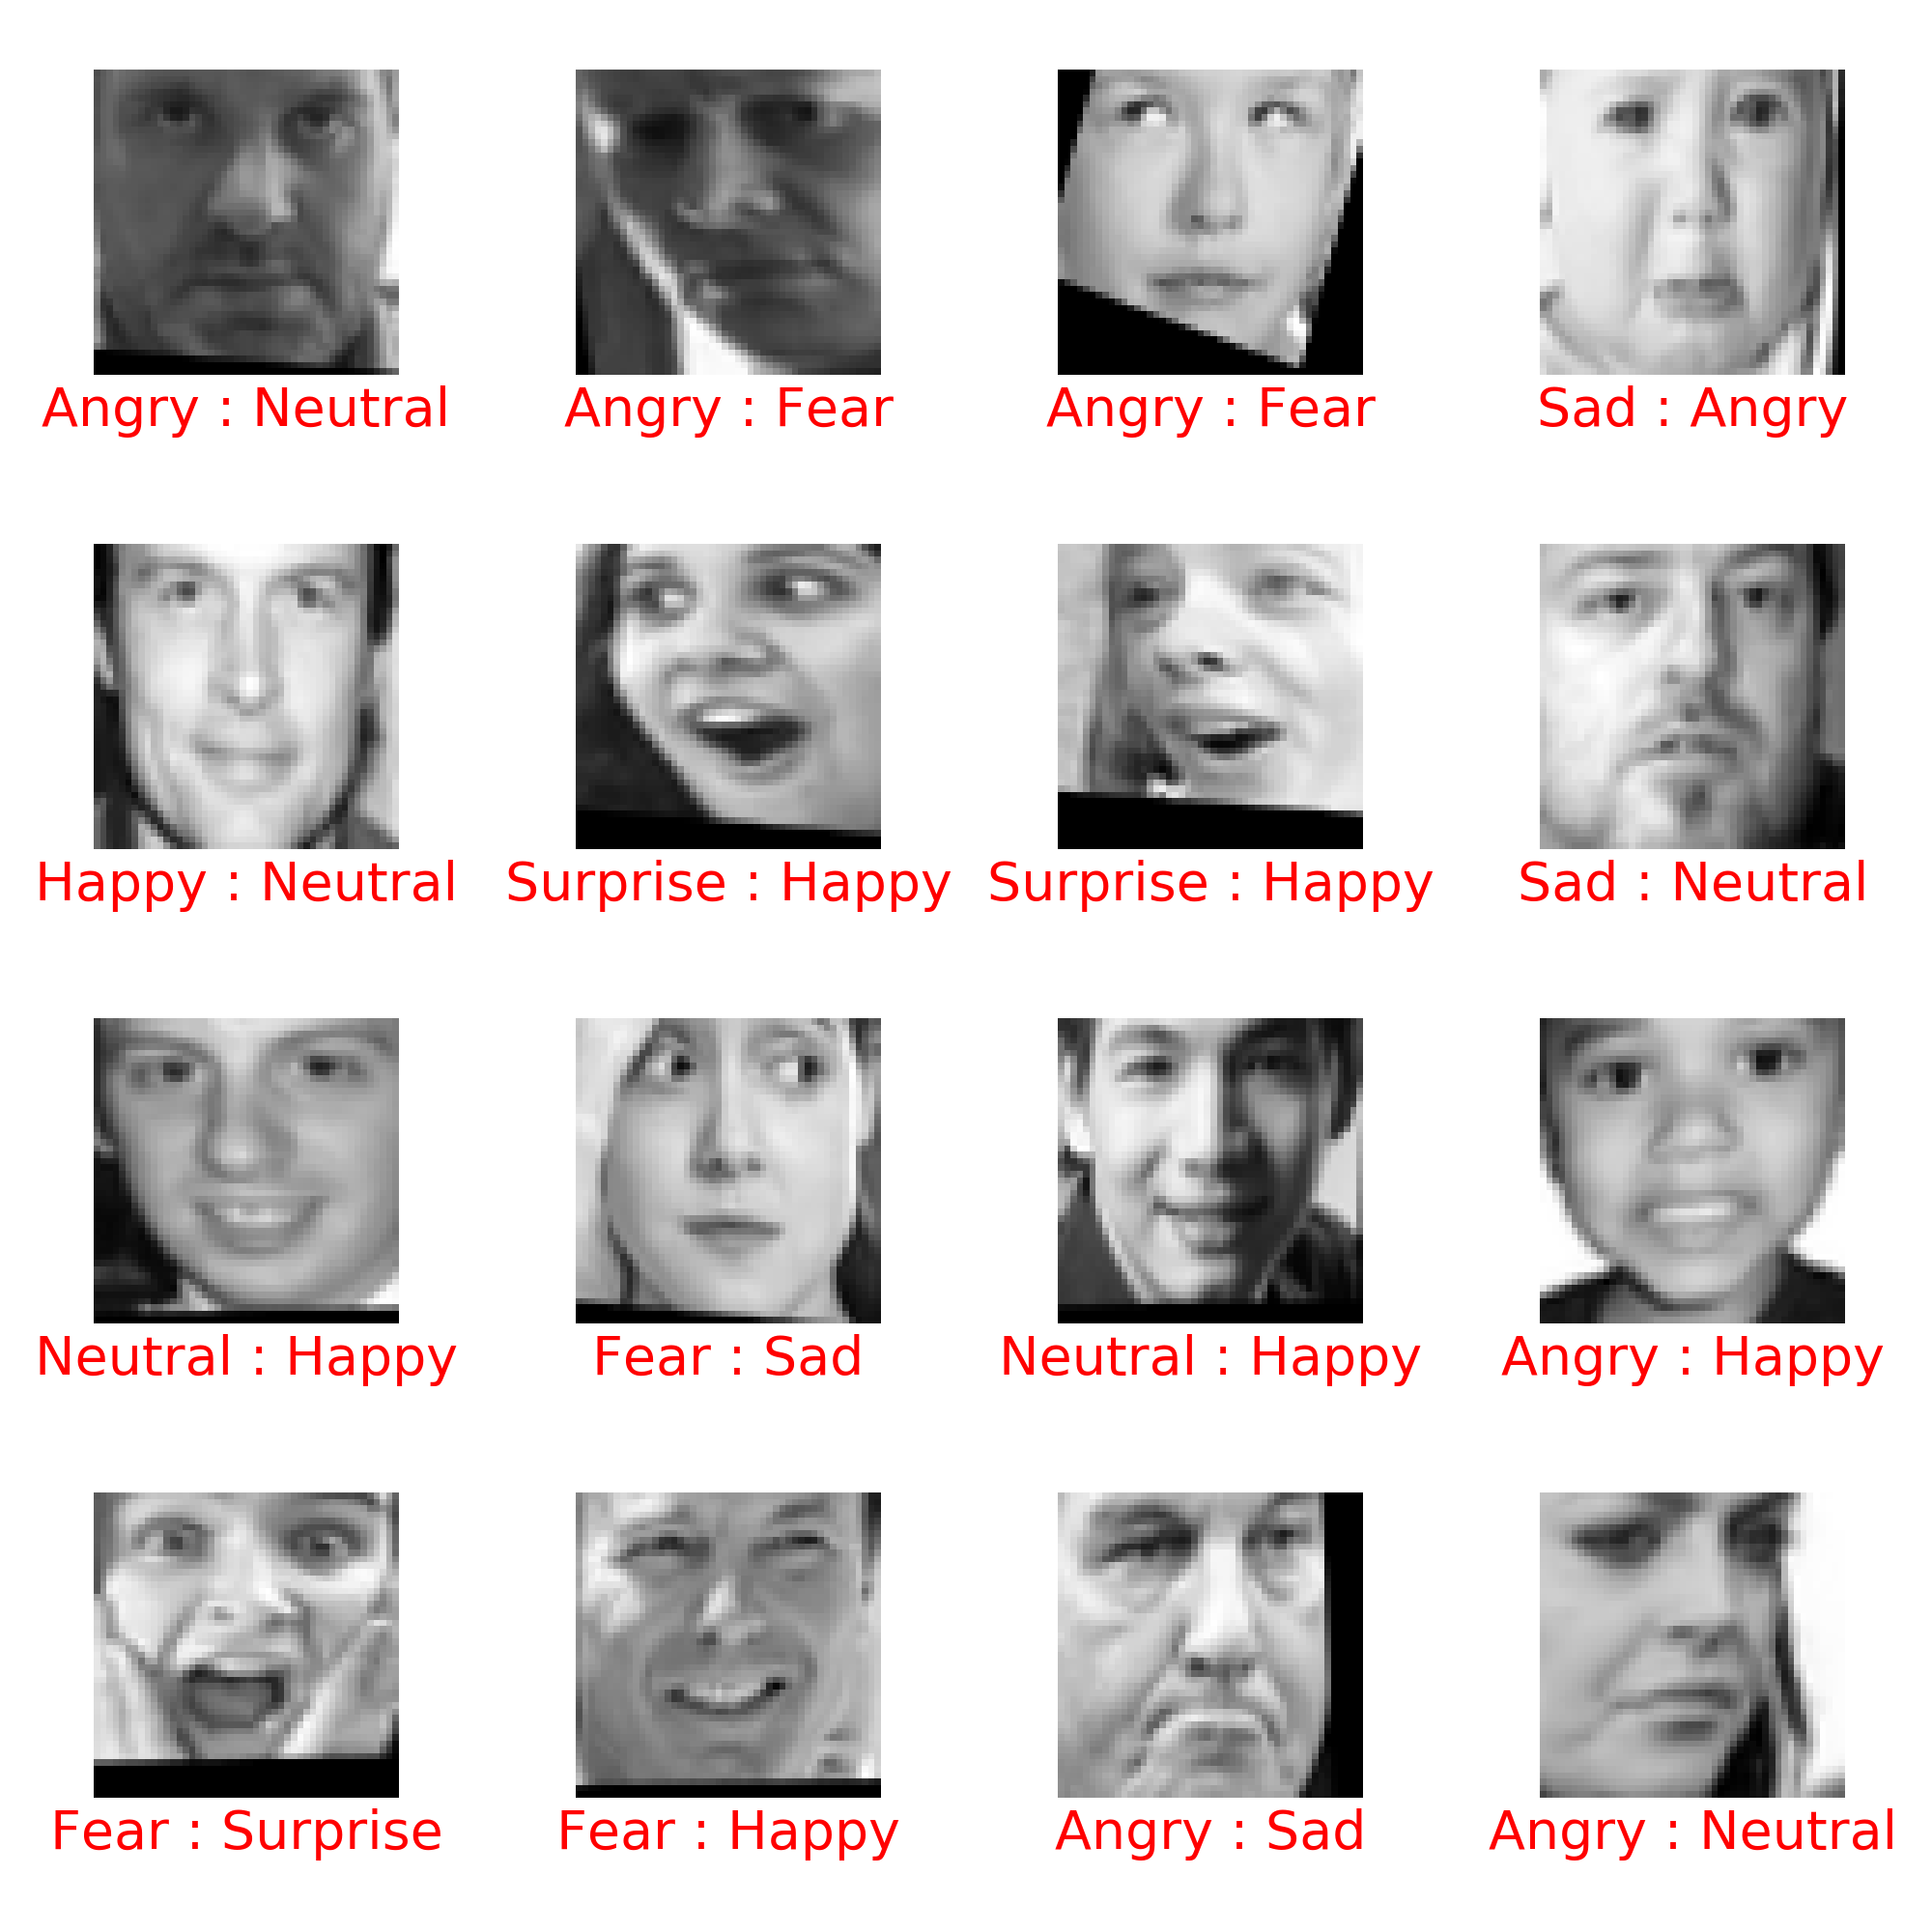

In [251]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=False)
plt.savefig('Images/wrong_prediction.png',dpi=600)

## Visulization of Weights and Outputs
### Helper Functions

In [409]:
import math
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids,figsize=(6,6))

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap=ocean.diverging.Balance_20.mpl_colormap)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [427]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids,figsize=(8,8))

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.ravel()):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='gray')#ocean.diverging.Balance_20.mpl_colormap)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Visualize the weights of individual layers and outputs

<IPython.core.display.Javascript object>


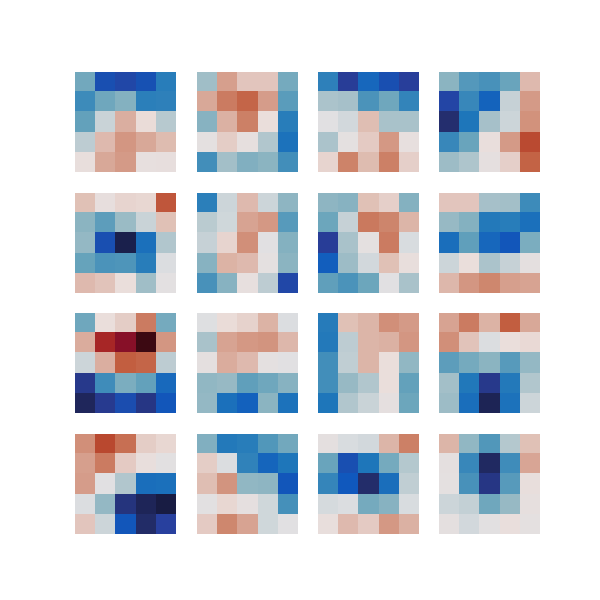

In [421]:
plot_conv_weights(W1_conv)
plt.savefig('Images/W1_conv.png',dpi=600)

<IPython.core.display.Javascript object>


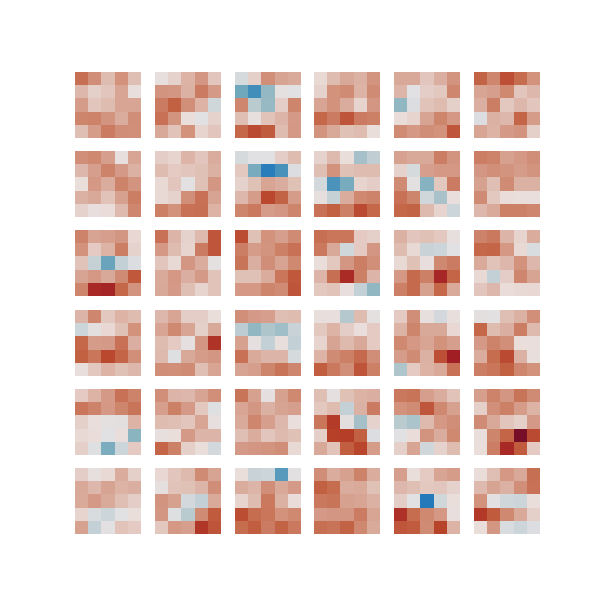

<IPython.core.display.Javascript object>


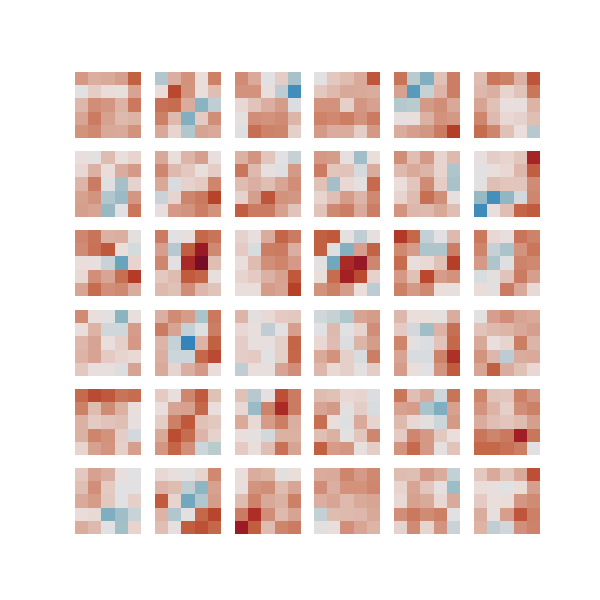

<IPython.core.display.Javascript object>


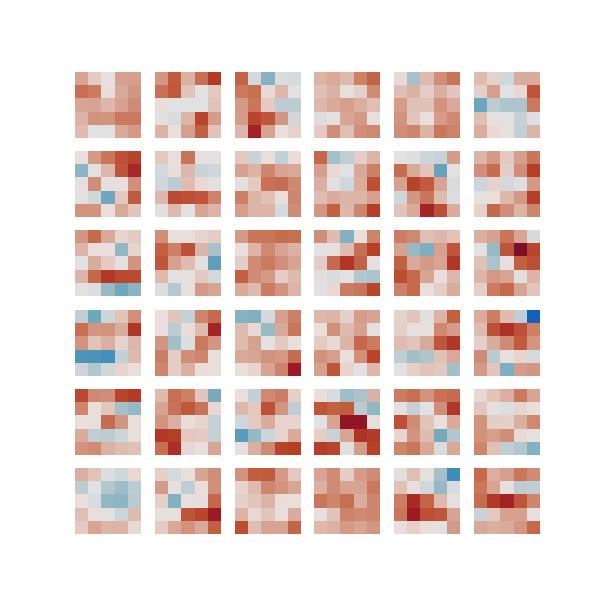

In [420]:
for i in range(3):
    plot_conv_weights(W2_conv,input_channel=i+2)
    plt.savefig('Images/W2_conv_'+str(i+2),dpi=600)

<IPython.core.display.Javascript object>


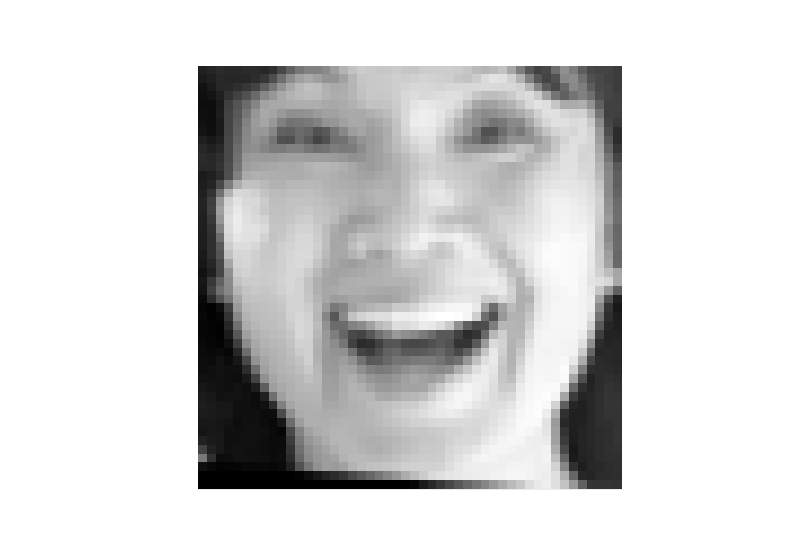

In [437]:
fig,ax=plt.subplots()
ax.imshow(train_x[89].reshape(-1,48),cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
plt.grid(False)
fig.savefig('Images/input_image.png',dpi=600)

<IPython.core.display.Javascript object>


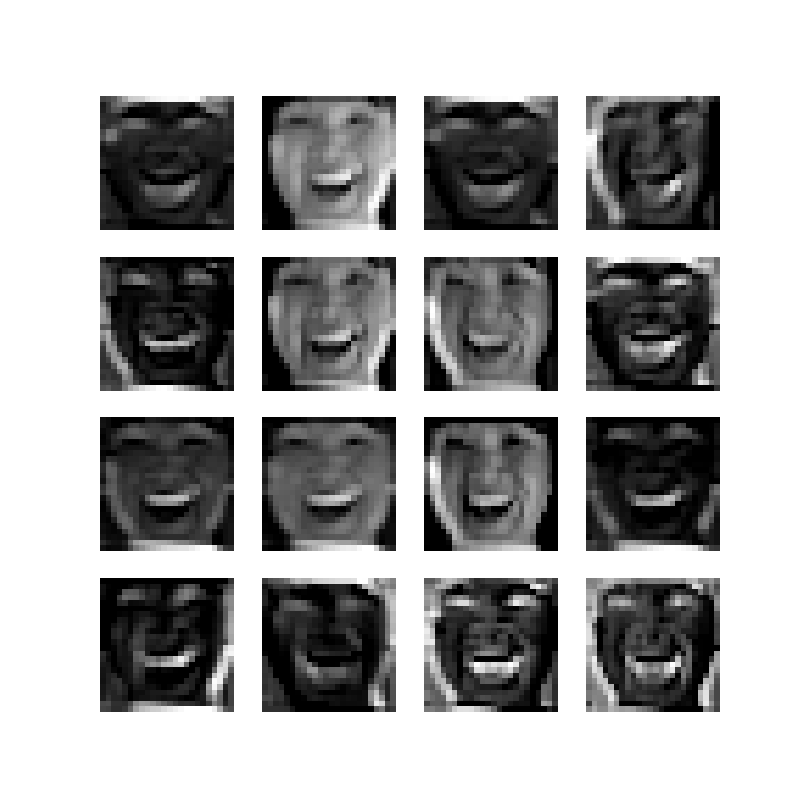

In [440]:
plot_conv_layer(L1_conv,train_x[89])
plt.savefig('Images/L1_conv_out.png',dpi=600)

<IPython.core.display.Javascript object>


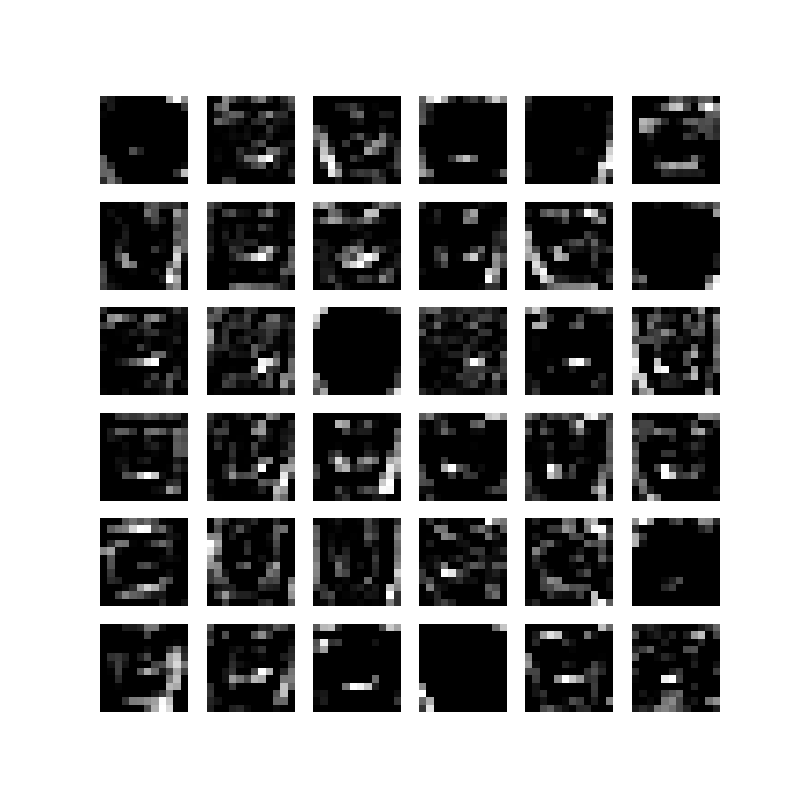

In [441]:
plot_conv_layer(L2_conv,train_x[89])
plt.savefig('Images/L2_conv_out.png',dpi=600)

In [50]:
test_dataset={"test_x":test_x,"test_y":test_y}

In [51]:
jb.dump(test_dataset,'test_dataset.pkl')

['test_dataset.pkl']